- Notebook tiếp cận giải quyết bài toán Brain Tumor Classification bằng phương pháp Transfer learning trên model EfficientNet.

# 1. Chuẩn bị dữ liệu:

## 1.1. Load dữ liệu từ Medely 12k ảnh:

In [ ]:
# Kết nối tới drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import các thư viện cần thiết:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

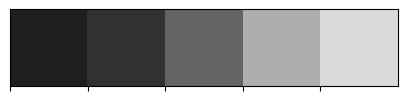

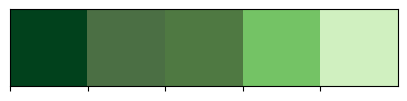

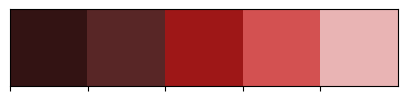

In [ ]:
# Colors sẽ sử dụng:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
# Tập nhãn:
labels = ['glioma','meningioma','notumor', 'pituitary']

In [ ]:
import zipfile
import os

# Tải lên dataset và giải nén:
zip_path = "/content/drive/MyDrive/Image_Processing_And_Application/Do_An/Epic and CSCR hospital Dataset.zip"
extract_path = "/content/brain_tumor"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Extracted!")

Extracted!


In [ ]:
train_dir = "/content/brain_tumor/Epic and CSCR hospital Dataset/Train"
test_dir  = "/content/brain_tumor/Epic and CSCR hospital Dataset/Test"

In [ ]:
# Đọc dữ liệu:
X_train_data = []
y_train_data = []
X_test_data = []
y_test_data = []
image_size = 224

# Load training data
for i in labels:
    folderPath = os.path.join(train_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading training {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train_data.append(img)
        y_train_data.append(i)

# Load testing data
for i in labels:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading testing {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test_data.append(img)
        y_test_data.append(i)

X_train_data = np.array(X_train_data)
y_train_data = np.array(y_train_data)
X_test_data = np.array(X_test_data)
y_test_data = np.array(y_test_data)

print(f"Original training data shape: {X_train_data.shape}")
print(f"Original testing data shape: {X_test_data.shape}")

Loading testing pituitary: 100%|██████████| 626/626 [00:01<00:00, 589.34it/s]


Original training data shape: (9650, 224, 224, 3)
Original testing data shape: (2414, 224, 224, 3)


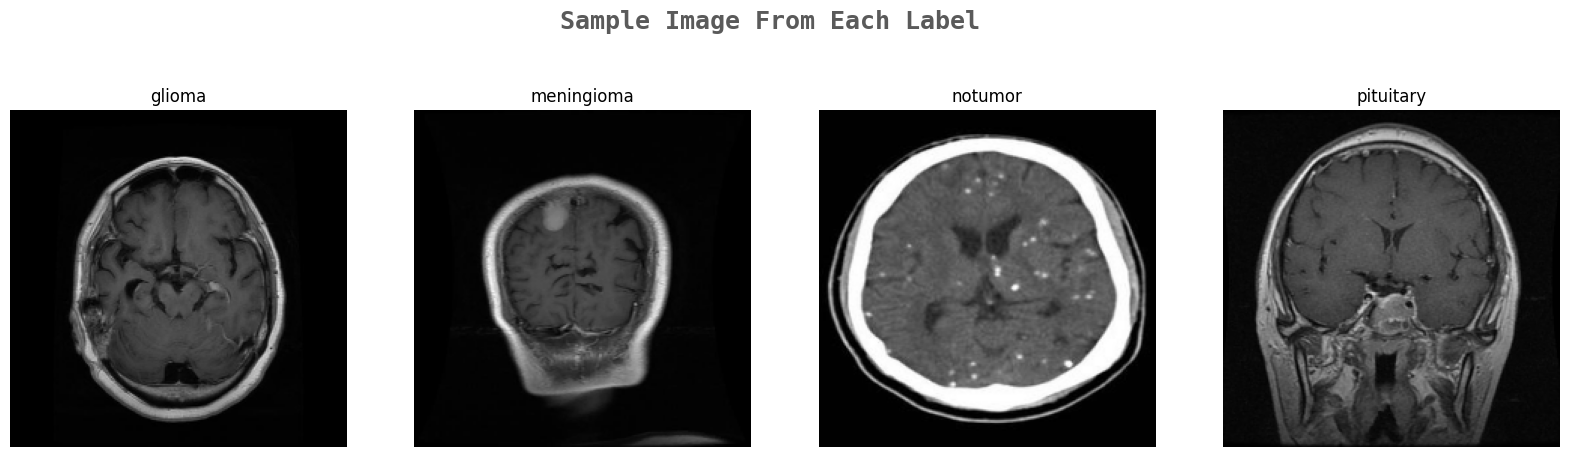

In [ ]:
# In ra một vài mẫu dữ liệu:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train_data[j]==i:
            ax[k].imshow(X_train_data[j])
            ax[k].set_title(y_train_data[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

### Kiểm tra dữ liệu có bị leak không:

In [ ]:
# Kiểm tra trùng ảnh trong train và test:
!pip install imagehash tqdm scikit-learn

import os, hashlib, csv, time
from PIL import Image
import imagehash
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

# CONFIG:
TRAIN_DIR = "/content/brain_tumor/Epic and CSCR hospital Dataset/Train"
TEST_DIR  = "/content/brain_tumor/Epic and CSCR hospital Dataset/Test"

# Output files
OUT_DIR = "/content/leak_check_output"
os.makedirs(OUT_DIR, exist_ok=True)
MD5_CSV = os.path.join(OUT_DIR, "md5_duplicates.csv")
PHASH_CSV = os.path.join(OUT_DIR, "phash_matches.csv")
EMBED_CSV = os.path.join(OUT_DIR, "embedding_nn_matches.csv")
SCORE_JSON = os.path.join(OUT_DIR, "leak_risk_summary.csv")

# Parameters (tuneable)
PHASH_HAMMING_THRESH = 8       # this hamming distance considered 'near-duplicate' (0.64 for 64-bit phash)
EMBED_SIMILARITY_THRESH = 0.35 # cosine distance threshold (lower means more similar). We'll use normalized euclidean ~ cosine proxy
NN_K = 1                       # nearest neighbor to check
BATCH_SIZE = 64                # embedding batchsize
IMAGE_SIZE = (224,224)         # input size for EfficientNetB0 feature extractor

# Weights for leak risk score
W_MD5 = 0.4
W_PHASH = 0.3
W_EMBED = 0.3

# Utility functions:
def md5_of_file(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def list_images_in_dir(root):
    files=[]
    for dirpath, dirnames, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff","bmp")):
                files.append(os.path.join(dirpath, fn))
    return sorted(files)

# STEP 1: MD5 duplicate check:
print("STEP 1: MD5 duplicates (exact matches) ...")
t0 = time.time()
train_files = list_images_in_dir(TRAIN_DIR)
test_files  = list_images_in_dir(TEST_DIR)
print(f"Found {len(train_files)} train images, {len(test_files)} test images")

# Build map of md5 for train
train_md5 = {}
for p in tqdm(train_files, desc="Hashing train"):
    try:
        h = md5_of_file(p)
        train_md5.setdefault(h, []).append(p)
    except Exception as e:
        print("Error reading", p, e)

duplicates = []
for p in tqdm(test_files, desc="Checking test md5"):
    try:
        h = md5_of_file(p)
        if h in train_md5:
            # record each match
            for tp in train_md5[h]:
                duplicates.append({"test_path": p, "train_path": tp, "md5": h})
    except Exception as e:
        print("Error reading", p, e)

# Save duplicates
pd.DataFrame(duplicates).to_csv(MD5_CSV, index=False)
print(f"MD5 duplicates found: {len(duplicates)}. Saved to {MD5_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 2: Perceptual hash (pHash) similarity
# We'll compute 64-bit pHash via imagehash.phash and measure Hamming distance
print("\nSTEP 2: Perceptual hash (pHash) similarity ...")
t0 = time.time()
# compute phashes for train and test (store as integers)
def compute_phash_map(file_list, hash_size=16):
    phash_map = {}
    for p in tqdm(file_list):
        try:
            img = Image.open(p).convert('L')  # convert to grayscale
            ph = imagehash.phash(img, hash_size=hash_size)  # 16 => 256-bit? but imagehash returns object
            # store as hex string
            phash_map[p] = ph
        except Exception as e:
            print("Error phash", p, e)
    return phash_map

train_phash = compute_phash_map(train_files, hash_size=16)
test_phash  = compute_phash_map(test_files, hash_size=16)

# Compare: for efficiency, create list of train phash values
train_items = list(train_phash.items())  # (path, phash)
train_hashes = [h for (_,h) in train_items]
train_paths = [p for (p,_) in train_items]

# For each test image, find any train image with hamming distance <= threshold
phash_matches = []
for tp, th in tqdm(test_phash.items(), desc="Comparing phash"):
    for i, tr_h in enumerate(train_hashes):
        # imagehash ImageHash supports - to get hamming distance
        dist = th - tr_h
        if dist <= PHASH_HAMMING_THRESH:
            phash_matches.append({
                "test_path": tp,
                "train_path": train_paths[i],
                "hamming": int(dist),
                "test_phash": str(th),
                "train_phash": str(tr_h)
            })
# Save
pd.DataFrame(phash_matches).to_csv(PHASH_CSV, index=False)
print(f"Perceptual-hash near-duplicates found: {len(phash_matches)}. Saved to {PHASH_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 3: Embedding-based similarity (feature extractor + NN)
print("\nSTEP 3: Embedding NN similarity ...")
t0 = time.time()

# Build EfficientNetB0 feature extractor (global average pooling)
feat_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', pooling='avg', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Preprocess input helper
preprocess = tf.keras.applications.efficientnet.preprocess_input

def load_and_preprocess(path):
    img = Image.open(path).convert("RGB").resize(IMAGE_SIZE, Image.BILINEAR)
    arr = np.array(img).astype(np.float32)
    return preprocess(arr)

# Compute embeddings in batches to save memory
def compute_embeddings(file_list, batch_size=64):
    embeddings = []
    paths = []
    n = len(file_list)
    for i in tqdm(range(0, n, batch_size), desc="Embedding"):
        batch_files = file_list[i:i+batch_size]
        batch_imgs = np.stack([load_and_preprocess(p) for p in batch_files], axis=0)
        emb = feat_model.predict(batch_imgs, verbose=0)
        embeddings.append(emb)
        paths.extend(batch_files)
    embeddings = np.vstack(embeddings)
    return paths, embeddings

train_paths_e, train_emb = compute_embeddings(train_files, batch_size=BATCH_SIZE)
test_paths_e, test_emb   = compute_embeddings(test_files, batch_size=BATCH_SIZE)
print("Train emb shape:", train_emb.shape, "Test emb shape:", test_emb.shape)

# Normalize embeddings (L2) to use cosine-like distance via euclidean on normalized vectors
def l2_normalize(x):
    norms = np.linalg.norm(x, axis=1, keepdims=True) + 1e-10
    return x / norms

train_emb_n = l2_normalize(train_emb)
test_emb_n  = l2_normalize(test_emb)

# Fit nearest neighbors on train embeddings
nbrs = NearestNeighbors(n_neighbors=NN_K, algorithm='auto', metric='euclidean').fit(train_emb_n)
distances, indices = nbrs.kneighbors(test_emb_n)  # distances are euclidean between unit vectors -> related to cosine

# distances is array (num_test, K)
# convert euclidean distance between normalized vectors to cosine similarity if needed:
# cosine_sim = 1 - 0.5 * (dist^2)  (relation)
embedding_matches = []
for i, dlist in enumerate(distances):
    d0 = float(dlist[0])
    idx0 = int(indices[i][0])
    train_p = train_paths_e[idx0]
    test_p  = test_paths_e[i]
    # Convert euclidean distance to approximate cosine similarity:
    # For unit vectors u,v: ||u-v||^2 = 2 - 2*cos => cos = 1 - (||u-v||^2)/2
    cos_sim = 1.0 - (d0*d0)/2.0
    # We'll consider match if d0 <= EMBED_SIMILARITY_THRESH (euclidean) OR cos_sim >= threshold_cos
    embedding_matches.append({
        "test_path": test_p,
        "train_path": train_p,
        "euclidean": d0,
        "cosine_approx": cos_sim
    })

pd.DataFrame(embedding_matches).to_csv(EMBED_CSV, index=False)
print(f"Embedding NN matches saved to {EMBED_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 4: Summarize and compute leak risk scorescore:
print("\nSTEP 4: Summarize results & compute leak risk score ...")
# counts
num_test = len(test_files)
md5_count = len(duplicates)
phash_count = len(phash_matches)

# For embedding, count how many test have euclidean distance <= threshold
embed_close = sum(1 for m in embedding_matches if m["euclidean"] <= EMBED_SIMILARITY_THRESH)

# Percentages
pct_md5 = md5_count / num_test
pct_phash = phash_count / num_test
pct_embed = embed_close / num_test

# Simple weighted score (0..1)
leak_score = W_MD5 * pct_md5 + W_PHASH * pct_phash + W_EMBED * pct_embed

summary = {
    "num_train": len(train_files),
    "num_test": num_test,
    "md5_matches": md5_count,
    "phash_matches": phash_count,
    "embed_close": embed_close,
    "pct_md5": pct_md5,
    "pct_phash": pct_phash,
    "pct_embed": pct_embed,
    "leak_score": leak_score,
    "phash_hamming_thresh": PHASH_HAMMING_THRESH,
    "embed_euclid_thresh": EMBED_SIMILARITY_THRESH
}

pd.DataFrame([summary]).to_csv(SCORE_JSON, index=False)
print("Summary saved to:", SCORE_JSON)
print(pd.DataFrame([summary]).T)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 19.5 MB/s eta 0:00:00
STEP 1: MD5 duplicates (exact matches) ...
Found 9650 train images, 2414 test images


Checking test md5: 100%|██████████| 2414/2414 [00:00<00:00, 13242.87it/s]


MD5 duplicates found: 315. Saved to /content/leak_check_output/md5_duplicates.csv. Time: 0.8s

STEP 2: Perceptual hash (pHash) similarity ...


Comparing phash: 100%|██████████| 2414/2414 [01:19<00:00, 30.29it/s]


Perceptual-hash near-duplicates found: 3212. Saved to /content/leak_check_output/phash_matches.csv. Time: 111.3s

STEP 3: Embedding NN similarity ...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Embedding: 100%|██████████| 38/38 [00:25<00:00,  1.48it/s]


Train emb shape: (9650, 1280) Test emb shape: (2414, 1280)
Embedding NN matches saved to /content/leak_check_output/embedding_nn_matches.csv. Time: 125.1s

STEP 4: Summarize results & compute leak risk score ...
Summary saved to: /content/leak_check_output/leak_risk_summary.csv
                                0
num_train             9650.000000
num_test              2414.000000
md5_matches            315.000000
phash_matches         3212.000000
embed_close           1845.000000
pct_md5                  0.130489
pct_phash                1.330572
pct_embed                0.764292
leak_score               0.680655
phash_hamming_thresh     8.000000
embed_euclid_thresh      0.350000


- Nhận xét, bộ dữ liệu bị rò rỉ khá nặng, với 315 ảnh trong tập test giống hoàn toàn với train.
- 3212 cặp ảnh trong test set gần giống với ảnh trong train set. Khoảng 1330 ảnh trong test giống gần như y hệt ảnh train (1.33%).
→ Đây là dấu hiệu dataset nhiễm ảnh duplicate dạng nhẹ hoặc ảnh augment thủ công.
- embed_close = 1845. So sánh embedding model → kiểm tra ảnh nội dung gần giống, kể cả khi khác màu, crop, artifact MRI.👉 76.43% ảnh test có embedding rất gần train
→ Khả năng cao đây là cùng bệnh nhân, cùng ca chụp, hoặc cùng lát MRI.
Leak score ~ 0.68 trên thang 001 nghĩa là dataset bị leak khá nghiêm trọng.

### Gộp thành dữ liệu train:

***=> Ta sẽ gộp hai tập train và test của dataset này lại thành một tập train mới và test model trên dataset khác***

In [ ]:
# Gộp train và test thành tập train mới:
X_train_data = np.concatenate((X_train_data, X_test_data), axis=0)
y_train_data = np.concatenate((y_train_data, y_test_data), axis=0)
print(f"New training data shape: {X_train_data.shape}")

New training data shape: (12064, 224, 224, 3)


In [ ]:
X_train_data, y_train_data = shuffle(X_train_data,y_train_data, random_state=101)

In [ ]:
X_train_data.shape

(12064, 224, 224, 3)

In [ ]:
y_train_data.shape

(12064,)

In [ ]:
# Split original training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=101)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (9651, 224, 224, 3)
Validation set shape: (2413, 224, 224, 3)


In [ ]:
# Performing One Hot Encoding on the labels after converting it into numerical values:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

In [ ]:
y_train.shape

(9651, 4)

In [ ]:
y_val.shape

(2413, 4)

## 1.2. Load dữ liệu test từ bộ dữ liệu Simezu từ Huggie Face:

***Tải dataset Simezu - brain-tumour-MRI-scan làm tập test:***

In [ ]:
!sudo apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/datasets/Simezu/brain-tumour-MRI-scan

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Git LFS initialized.
fatal: destination path 'brain-tumour-MRI-scan' already exists and is not an empty directory.


In [ ]:
import os

root = "/content/brain-tumour-MRI-scan"
classes_new = sorted(os.listdir(os.path.join(root, "Training")))
print(classes_new)


['1-notumor', '2-glioma', '3-meningioma', '4-pituitary']


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

new_train_dir = os.path.join(root, "Training")
new_test_dir = os.path.join(root, "Testing")

X_new_test_data = []
y_new_test_data = []
image_size = 224

label_map = {
    '1-notumor': 'notumor',
    '2-glioma': 'glioma',
    '3-meningioma': 'meningioma',
    '4-pituitary': 'pituitary'
}

# Helper function to load data from a directory
def load_images_from_directory(directory, X_list, y_list, map_dict, current_labels_list, img_size, desc_prefix):
    for folder_name in tqdm(os.listdir(directory), desc=f"{desc_prefix} {directory.split('/')[-1]}"):
        full_folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(full_folder_path):
            # Ensure the folder_name is in the map_dict
            if folder_name in map_dict:
                mapped_label = map_dict[folder_name]
                for image_file in os.listdir(full_folder_path):
                    img_path = os.path.join(full_folder_path, image_file)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.resize(img, (img_size, img_size))
                            X_list.append(img)
                            y_list.append(mapped_label)
                        else:
                            print(f"Warning: Could not read image {img_path}")
                    except Exception as e:
                        print(f"Error processing image {img_path}: {e}")

# 5. Load data from the 'Training' split of the new dataset
print(f"Loading images from new training directory: {new_train_dir}")
load_images_from_directory(new_train_dir, X_new_test_data, y_new_test_data, label_map, labels, image_size, "Loading New Train")

# 6. Load data from the 'Testing' split of the new dataset
print(f"Loading images from new testing directory: {new_test_dir}")
load_images_from_directory(new_test_dir, X_new_test_data, y_new_test_data, label_map, labels, image_size, "Loading New Test ")

# Convert lists to NumPy arrays
X_new_test_data = np.array(X_new_test_data)
y_new_test_data = np.array(y_new_test_data)

print(f"Shape of X_new_test_data: {X_new_test_data.shape}")
print(f"Shape of y_new_test_data: {y_new_test_data.shape}")

Loading images from new training directory: /content/brain-tumour-MRI-scan/Training


Loading New Train Training: 100%|██████████| 4/4 [00:12<00:00,  3.16s/it]


Loading images from new testing directory: /content/brain-tumour-MRI-scan/Testing


Loading New Test  Testing: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Shape of X_new_test_data: (7023, 224, 224, 3)
Shape of y_new_test_data: (7023,)


In [ ]:
X_test = X_new_test_data
y_test = y_new_test_data

print(f"Final X_test shape: {X_test.shape}")
print(f"Final y_test shape: {y_test.shape}")

Final X_test shape: (7023, 224, 224, 3)
Final y_test shape: (7023,)


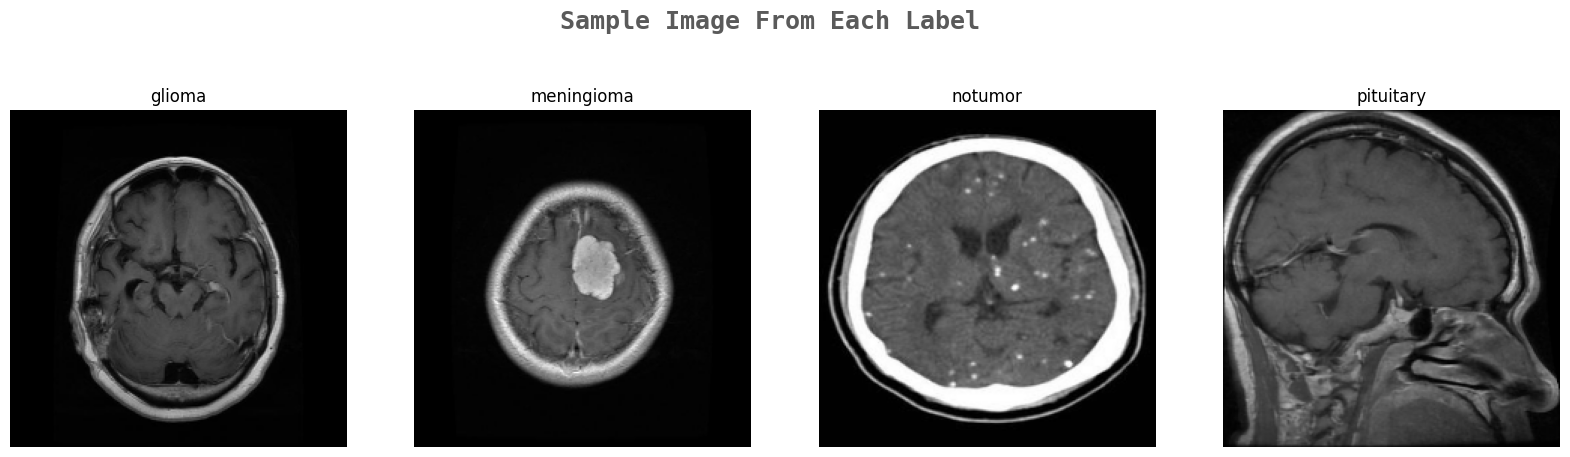

In [ ]:
# In ra một vài mẫu ảnh test:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_test[j]==i:
            ax[k].imshow(X_test[j])
            ax[k].set_title(y_test[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
# One-hot encoding cho y_test:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_test.shape

(7023, 4)

### Kiểm tra rò rĩ dữ liệu:

In [ ]:
# Kiểm tra có rò rỉ dữ liệu giữa train và test không:
# Kiểm tra trùng ảnh trong train và test:
!pip install imagehash tqdm scikit-learn

import os, hashlib, csv, time
from PIL import Image
import imagehash
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

# CONFIG:
TRAIN_DIR = "/content/brain_tumor/Epic and CSCR hospital Dataset"
TEST_DIR  = "/content/brain-tumour-MRI-scan"

# Output files
OUT_DIR = "/content/leak_check_output2"
os.makedirs(OUT_DIR, exist_ok=True)
MD5_CSV = os.path.join(OUT_DIR, "md5_duplicates.csv")
PHASH_CSV = os.path.join(OUT_DIR, "phash_matches.csv")
EMBED_CSV = os.path.join(OUT_DIR, "embedding_nn_matches.csv")
SCORE_JSON = os.path.join(OUT_DIR, "leak_risk_summary.csv")

# Parameters (tuneable)
PHASH_HAMMING_THRESH = 8       # this hamming distance considered 'near-duplicate' (0.64 for 64-bit phash)
EMBED_SIMILARITY_THRESH = 0.35 # cosine distance threshold (lower means more similar). We'll use normalized euclidean ~ cosine proxy
NN_K = 1                       # nearest neighbor to check
BATCH_SIZE = 64                # embedding batchsize
IMAGE_SIZE = (224,224)         # input size for EfficientNetB0 feature extractor

# Weights for leak risk score
W_MD5 = 0.4
W_PHASH = 0.3
W_EMBED = 0.3

# Utility functions:
def md5_of_file(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def list_images_in_dir(root):
    files=[]
    for dirpath, dirnames, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff","bmp")):
                files.append(os.path.join(dirpath, fn))
    return sorted(files)

# STEP 1: MD5 duplicate check:
print("STEP 1: MD5 duplicates (exact matches) ...")
t0 = time.time()
train_files = list_images_in_dir(TRAIN_DIR)
test_files  = list_images_in_dir(TEST_DIR)
print(f"Found {len(train_files)} train images, {len(test_files)} test images")

# Build map of md5 for train
train_md5 = {}
for p in tqdm(train_files, desc="Hashing train"):
    try:
        h = md5_of_file(p)
        train_md5.setdefault(h, []).append(p)
    except Exception as e:
        print("Error reading", p, e)

duplicates = []
for p in tqdm(test_files, desc="Checking test md5"):
    try:
        h = md5_of_file(p)
        if h in train_md5:
            # record each match
            for tp in train_md5[h]:
                duplicates.append({"test_path": p, "train_path": tp, "md5": h})
    except Exception as e:
        print("Error reading", p, e)

# Save duplicates
pd.DataFrame(duplicates).to_csv(MD5_CSV, index=False)
print(f"MD5 duplicates found: {len(duplicates)}. Saved to {MD5_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 2: Perceptual hash (pHash) similarity
# We'll compute 64-bit pHash via imagehash.phash and measure Hamming distance
print("\nSTEP 2: Perceptual hash (pHash) similarity ...")
t0 = time.time()
# compute phashes for train and test (store as integers)
def compute_phash_map(file_list, hash_size=16):
    phash_map = {}
    for p in tqdm(file_list):
        try:
            img = Image.open(p).convert('L')  # convert to grayscale
            ph = imagehash.phash(img, hash_size=hash_size)  # 16 => 256-bit? but imagehash returns object
            # store as hex string
            phash_map[p] = ph
        except Exception as e:
            print("Error phash", p, e)
    return phash_map

train_phash = compute_phash_map(train_files, hash_size=16)
test_phash  = compute_phash_map(test_files, hash_size=16)

# Compare: for efficiency, create list of train phash values
train_items = list(train_phash.items())  # (path, phash)
train_hashes = [h for (_,h) in train_items]
train_paths = [p for (p,_) in train_items]

# For each test image, find any train image with hamming distance <= threshold
phash_matches = []
for tp, th in tqdm(test_phash.items(), desc="Comparing phash"):
    for i, tr_h in enumerate(train_hashes):
        # imagehash ImageHash supports - to get hamming distance
        dist = th - tr_h
        if dist <= PHASH_HAMMING_THRESH:
            phash_matches.append({
                "test_path": tp,
                "train_path": train_paths[i],
                "hamming": int(dist),
                "test_phash": str(th),
                "train_phash": str(tr_h)
            })
# Save
pd.DataFrame(phash_matches).to_csv(PHASH_CSV, index=False)
print(f"Perceptual-hash near-duplicates found: {len(phash_matches)}. Saved to {PHASH_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 3: Embedding-based similarity (feature extractor + NN)
print("\nSTEP 3: Embedding NN similarity ...")
t0 = time.time()

# Build EfficientNetB0 feature extractor (global average pooling)
feat_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', pooling='avg', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Preprocess input helper
preprocess = tf.keras.applications.efficientnet.preprocess_input

def load_and_preprocess(path):
    img = Image.open(path).convert("RGB").resize(IMAGE_SIZE, Image.BILINEAR)
    arr = np.array(img).astype(np.float32)
    return preprocess(arr)

# Compute embeddings in batches to save memory
def compute_embeddings(file_list, batch_size=64):
    embeddings = []
    paths = []
    n = len(file_list)
    for i in tqdm(range(0, n, batch_size), desc="Embedding"):
        batch_files = file_list[i:i+batch_size]
        batch_imgs = np.stack([load_and_preprocess(p) for p in batch_files], axis=0)
        emb = feat_model.predict(batch_imgs, verbose=0)
        embeddings.append(emb)
        paths.extend(batch_files)
    embeddings = np.vstack(embeddings)
    return paths, embeddings

train_paths_e, train_emb = compute_embeddings(train_files, batch_size=BATCH_SIZE)
test_paths_e, test_emb   = compute_embeddings(test_files, batch_size=BATCH_SIZE)
print("Train emb shape:", train_emb.shape, "Test emb shape:", test_emb.shape)

# Normalize embeddings (L2) to use cosine-like distance via euclidean on normalized vectors
def l2_normalize(x):
    norms = np.linalg.norm(x, axis=1, keepdims=True) + 1e-10
    return x / norms

train_emb_n = l2_normalize(train_emb)
test_emb_n  = l2_normalize(test_emb)

# Fit nearest neighbors on train embeddings
nbrs = NearestNeighbors(n_neighbors=NN_K, algorithm='auto', metric='euclidean').fit(train_emb_n)
distances, indices = nbrs.kneighbors(test_emb_n)  # distances are euclidean between unit vectors -> related to cosine

# distances is array (num_test, K)
# convert euclidean distance between normalized vectors to cosine similarity if needed:
# cosine_sim = 1 - 0.5 * (dist^2)  (relation)
embedding_matches = []
for i, dlist in enumerate(distances):
    d0 = float(dlist[0])
    idx0 = int(indices[i][0])
    train_p = train_paths_e[idx0]
    test_p  = test_paths_e[i]
    # Convert euclidean distance to approximate cosine similarity:
    # For unit vectors u,v: ||u-v||^2 = 2 - 2*cos => cos = 1 - (||u-v||^2)/2
    cos_sim = 1.0 - (d0*d0)/2.0
    # We'll consider match if d0 <= EMBED_SIMILARITY_THRESH (euclidean) OR cos_sim >= threshold_cos
    embedding_matches.append({
        "test_path": test_p,
        "train_path": train_p,
        "euclidean": d0,
        "cosine_approx": cos_sim
    })

pd.DataFrame(embedding_matches).to_csv(EMBED_CSV, index=False)
print(f"Embedding NN matches saved to {EMBED_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 4: Summarize and compute leak risk scorescore:
print("\nSTEP 4: Summarize results & compute leak risk score ...")
# counts
num_test = len(test_files)
md5_count = len(duplicates)
phash_count = len(phash_matches)

# For embedding, count how many test have euclidean distance <= threshold
embed_close = sum(1 for m in embedding_matches if m["euclidean"] <= EMBED_SIMILARITY_THRESH)

# Percentages
pct_md5 = md5_count / num_test
pct_phash = phash_count / num_test
pct_embed = embed_close / num_test

# Simple weighted score (0..1)
leak_score = W_MD5 * pct_md5 + W_PHASH * pct_phash + W_EMBED * pct_embed

summary = {
    "num_train": len(train_files),
    "num_test": num_test,
    "md5_matches": md5_count,
    "phash_matches": phash_count,
    "embed_close": embed_close,
    "pct_md5": pct_md5,
    "pct_phash": pct_phash,
    "pct_embed": pct_embed,
    "leak_score": leak_score,
    "phash_hamming_thresh": PHASH_HAMMING_THRESH,
    "embed_euclid_thresh": EMBED_SIMILARITY_THRESH
}

pd.DataFrame([summary]).to_csv(SCORE_JSON, index=False)
print("Summary saved to:", SCORE_JSON)
print(pd.DataFrame([summary]).T)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 11.6 MB/s eta 0:00:00
STEP 1: MD5 duplicates (exact matches) ...
Found 12064 train images, 7023 test images


Checking test md5: 100%|██████████| 7023/7023 [00:00<00:00, 15547.52it/s]


MD5 duplicates found: 6506. Saved to /content/leak_check_output2/md5_duplicates.csv. Time: 6.2s

STEP 2: Perceptual hash (pHash) similarity ...


Comparing phash: 100%|██████████| 7023/7023 [04:56<00:00, 23.71it/s]


Perceptual-hash near-duplicates found: 15745. Saved to /content/leak_check_output2/phash_matches.csv. Time: 350.4s

STEP 3: Embedding NN similarity ...


Embedding: 100%|██████████| 110/110 [00:53<00:00,  2.06it/s]


Train emb shape: (12064, 1280) Test emb shape: (7023, 1280)
Embedding NN matches saved to /content/leak_check_output2/embedding_nn_matches.csv. Time: 138.6s

STEP 4: Summarize results & compute leak risk score ...
Summary saved to: /content/leak_check_output2/leak_risk_summary.csv
                                 0
num_train             12064.000000
num_test               7023.000000
md5_matches            6506.000000
phash_matches         15745.000000
embed_close            6733.000000
pct_md5                   0.926385
pct_phash                 2.241919
pct_embed                 0.958707
leak_score                1.330742
phash_hamming_thresh      8.000000
embed_euclid_thresh       0.350000


- Như vậy bộ dataset này cũng gần như copy từ dataset cũ, không thể dùng làm tập test.

## 1.3. Load bộ dữ liệu meddely 4k ảnh khác để làm test:

In [ ]:
import zipfile
import os

# Tải lên dataset và giải nén:
zip_path = "/content/drive/MyDrive/Image_Processing_And_Application/Đồ Án/Brain Tumor data.zip"
extract_path = "/content/brain_tumor_test_medely"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Extracted!")

Extracted!


In [ ]:
# Đọc dữ liệu:
X_train_data_medely = []
y_train_data_medely = []
X_test_data_medely = []
y_test_data_medely = []
image_size = 224

train_dir = "/content/brain_tumor_test_medely/Brain Tumor data/Training"
test_dir = "/content/brain_tumor_test_medely/Brain Tumor data/Testing"
# Load training data
for i in labels:
    folderPath = os.path.join(train_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading training {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train_data_medely.append(img)
        y_train_data_medely.append(i)

# Load testing data
for i in labels:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading testing {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test_data_medely.append(img)
        y_test_data_medely.append(i)

X_train_data_medely = np.array(X_train_data_medely)
y_train_data_medely = np.array(y_train_data_medely)
X_test_data_medely = np.array(X_test_data_medely)
y_test_data_medely = np.array(y_test_data_medely)

print(f"Original training data shape: {X_train_data_medely.shape}")
print(f"Original testing data shape: {X_test_data_medely.shape}")

Loading testing pituitary: 100%|██████████| 300/300 [00:00<00:00, 520.90it/s]


Original training data shape: (5712, 224, 224, 3)
Original testing data shape: (1311, 224, 224, 3)


In [ ]:
# Gộp hai tập train và test medely này thành một tập test medely mới:
X_test_data_medely = np.concatenate((X_test_data_medely, X_train_data_medely), axis=0)
y_test_data_medely = np.concatenate((y_test_data_medely, y_train_data_medely), axis=0)

print(f"Final testing data shape: {X_test_data_medely.shape}")

Final testing data shape: (7023, 224, 224, 3)


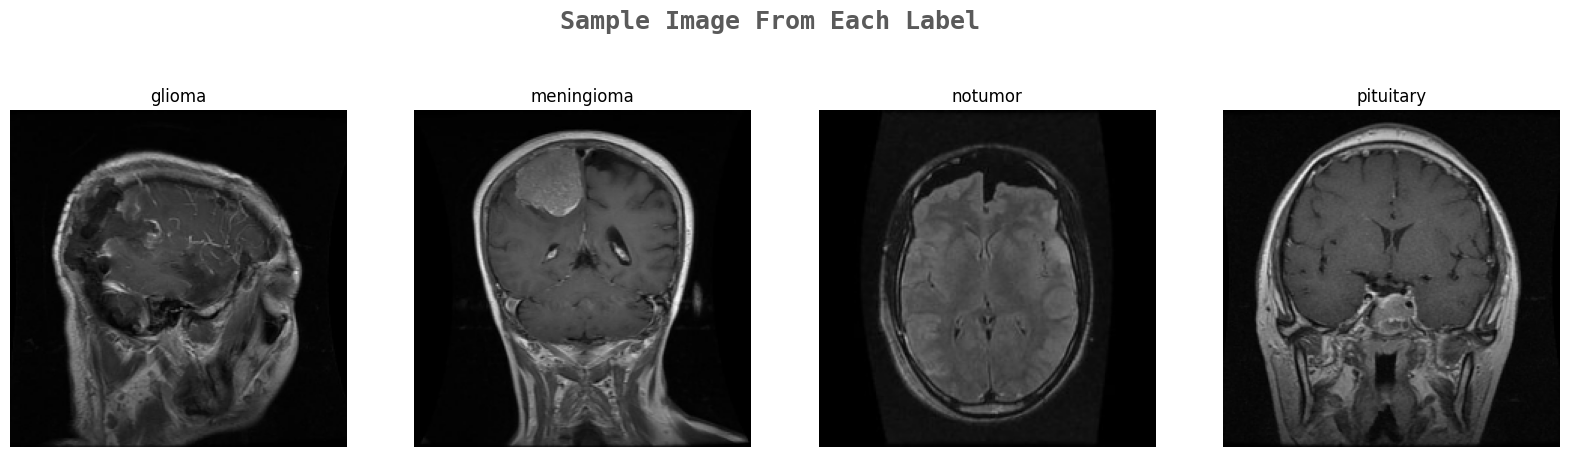

In [ ]:
# In ra một vài mẫu:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_test_data_medely[j]==i:
            ax[k].imshow(X_test_data_medely[j])
            ax[k].set_title(y_test_data_medely[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
# One hot encoding cho y_test_data_medely:
y_test_data_medely_new = []
for i in y_test_data_medely:
    y_test_data_medely_new.append(labels.index(i))
y_test_data_medely = y_test_data_medely_new
y_test_data_medely = tf.keras.utils.to_categorical(y_test_data_medely)

### Kiểm tra rò rỉ dữ liệu:

In [ ]:
# Kiểm tra rò rỉ dữ liệu so với tập train:
# Kiểm tra trùng ảnh trong train và test:
!pip install imagehash tqdm scikit-learn

import os, hashlib, csv, time
from PIL import Image
import imagehash
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

# CONFIG:
TRAIN_DIR = "/content/brain_tumor/Epic and CSCR hospital Dataset"
TEST_DIR  = "/content/brain_tumor_test_medely/Brain Tumor data"

# Output files
OUT_DIR = "/content/leak_check_output3"
os.makedirs(OUT_DIR, exist_ok=True)
MD5_CSV = os.path.join(OUT_DIR, "md5_duplicates.csv")
PHASH_CSV = os.path.join(OUT_DIR, "phash_matches.csv")
EMBED_CSV = os.path.join(OUT_DIR, "embedding_nn_matches.csv")
SCORE_JSON = os.path.join(OUT_DIR, "leak_risk_summary.csv")

# Parameters (tuneable)
PHASH_HAMMING_THRESH = 8       # this hamming distance considered 'near-duplicate' (0.64 for 64-bit phash)
EMBED_SIMILARITY_THRESH = 0.35 # cosine distance threshold (lower means more similar). We'll use normalized euclidean ~ cosine proxy
NN_K = 1                       # nearest neighbor to check
BATCH_SIZE = 64                # embedding batchsize
IMAGE_SIZE = (224,224)         # input size for EfficientNetB0 feature extractor

# Weights for leak risk score
W_MD5 = 0.4
W_PHASH = 0.3
W_EMBED = 0.3

# Utility functions:
def md5_of_file(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def list_images_in_dir(root):
    files=[]
    for dirpath, dirnames, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff","bmp")):
                files.append(os.path.join(dirpath, fn))
    return sorted(files)

# STEP 1: MD5 duplicate check:
print("STEP 1: MD5 duplicates (exact matches) ...")
t0 = time.time()
train_files = list_images_in_dir(TRAIN_DIR)
test_files  = list_images_in_dir(TEST_DIR)
print(f"Found {len(train_files)} train images, {len(test_files)} test images")

# Build map of md5 for train
train_md5 = {}
for p in tqdm(train_files, desc="Hashing train"):
    try:
        h = md5_of_file(p)
        train_md5.setdefault(h, []).append(p)
    except Exception as e:
        print("Error reading", p, e)

duplicates = []
for p in tqdm(test_files, desc="Checking test md5"):
    try:
        h = md5_of_file(p)
        if h in train_md5:
            # record each match
            for tp in train_md5[h]:
                duplicates.append({"test_path": p, "train_path": tp, "md5": h})
    except Exception as e:
        print("Error reading", p, e)

# Save duplicates
pd.DataFrame(duplicates).to_csv(MD5_CSV, index=False)
print(f"MD5 duplicates found: {len(duplicates)}. Saved to {MD5_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 2: Perceptual hash (pHash) similarity
# We'll compute 64-bit pHash via imagehash.phash and measure Hamming distance
print("\nSTEP 2: Perceptual hash (pHash) similarity ...")
t0 = time.time()
# compute phashes for train and test (store as integers)
def compute_phash_map(file_list, hash_size=16):
    phash_map = {}
    for p in tqdm(file_list):
        try:
            img = Image.open(p).convert('L')  # convert to grayscale
            ph = imagehash.phash(img, hash_size=hash_size)  # 16 => 256-bit? but imagehash returns object
            # store as hex string
            phash_map[p] = ph
        except Exception as e:
            print("Error phash", p, e)
    return phash_map

train_phash = compute_phash_map(train_files, hash_size=16)
test_phash  = compute_phash_map(test_files, hash_size=16)

# Compare: for efficiency, create list of train phash values
train_items = list(train_phash.items())  # (path, phash)
train_hashes = [h for (_,h) in train_items]
train_paths = [p for (p,_) in train_items]

# For each test image, find any train image with hamming distance <= threshold
phash_matches = []
for tp, th in tqdm(test_phash.items(), desc="Comparing phash"):
    for i, tr_h in enumerate(train_hashes):
        # imagehash ImageHash supports - to get hamming distance
        dist = th - tr_h
        if dist <= PHASH_HAMMING_THRESH:
            phash_matches.append({
                "test_path": tp,
                "train_path": train_paths[i],
                "hamming": int(dist),
                "test_phash": str(th),
                "train_phash": str(tr_h)
            })
# Save
pd.DataFrame(phash_matches).to_csv(PHASH_CSV, index=False)
print(f"Perceptual-hash near-duplicates found: {len(phash_matches)}. Saved to {PHASH_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 3: Embedding-based similarity (feature extractor + NN)
print("\nSTEP 3: Embedding NN similarity ...")
t0 = time.time()

# Build EfficientNetB0 feature extractor (global average pooling)
feat_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', pooling='avg', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Preprocess input helper
preprocess = tf.keras.applications.efficientnet.preprocess_input

def load_and_preprocess(path):
    img = Image.open(path).convert("RGB").resize(IMAGE_SIZE, Image.BILINEAR)
    arr = np.array(img).astype(np.float32)
    return preprocess(arr)

# Compute embeddings in batches to save memory
def compute_embeddings(file_list, batch_size=64):
    embeddings = []
    paths = []
    n = len(file_list)
    for i in tqdm(range(0, n, batch_size), desc="Embedding"):
        batch_files = file_list[i:i+batch_size]
        batch_imgs = np.stack([load_and_preprocess(p) for p in batch_files], axis=0)
        emb = feat_model.predict(batch_imgs, verbose=0)
        embeddings.append(emb)
        paths.extend(batch_files)
    embeddings = np.vstack(embeddings)
    return paths, embeddings

train_paths_e, train_emb = compute_embeddings(train_files, batch_size=BATCH_SIZE)
test_paths_e, test_emb   = compute_embeddings(test_files, batch_size=BATCH_SIZE)
print("Train emb shape:", train_emb.shape, "Test emb shape:", test_emb.shape)

# Normalize embeddings (L2) to use cosine-like distance via euclidean on normalized vectors
def l2_normalize(x):
    norms = np.linalg.norm(x, axis=1, keepdims=True) + 1e-10
    return x / norms

train_emb_n = l2_normalize(train_emb)
test_emb_n  = l2_normalize(test_emb)

# Fit nearest neighbors on train embeddings
nbrs = NearestNeighbors(n_neighbors=NN_K, algorithm='auto', metric='euclidean').fit(train_emb_n)
distances, indices = nbrs.kneighbors(test_emb_n)  # distances are euclidean between unit vectors -> related to cosine

# distances is array (num_test, K)
# convert euclidean distance between normalized vectors to cosine similarity if needed:
# cosine_sim = 1 - 0.5 * (dist^2)  (relation)
embedding_matches = []
for i, dlist in enumerate(distances):
    d0 = float(dlist[0])
    idx0 = int(indices[i][0])
    train_p = train_paths_e[idx0]
    test_p  = test_paths_e[i]
    # Convert euclidean distance to approximate cosine similarity:
    # For unit vectors u,v: ||u-v||^2 = 2 - 2*cos => cos = 1 - (||u-v||^2)/2
    cos_sim = 1.0 - (d0*d0)/2.0
    # We'll consider match if d0 <= EMBED_SIMILARITY_THRESH (euclidean) OR cos_sim >= threshold_cos
    embedding_matches.append({
        "test_path": test_p,
        "train_path": train_p,
        "euclidean": d0,
        "cosine_approx": cos_sim
    })

pd.DataFrame(embedding_matches).to_csv(EMBED_CSV, index=False)
print(f"Embedding NN matches saved to {EMBED_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 4: Summarize and compute leak risk scorescore:
print("\nSTEP 4: Summarize results & compute leak risk score ...")
# counts
num_test = len(test_files)
md5_count = len(duplicates)
phash_count = len(phash_matches)

# For embedding, count how many test have euclidean distance <= threshold
embed_close = sum(1 for m in embedding_matches if m["euclidean"] <= EMBED_SIMILARITY_THRESH)

# Percentages
pct_md5 = md5_count / num_test
pct_phash = phash_count / num_test
pct_embed = embed_close / num_test

# Simple weighted score (0..1)
leak_score = W_MD5 * pct_md5 + W_PHASH * pct_phash + W_EMBED * pct_embed

summary = {
    "num_train": len(train_files),
    "num_test": num_test,
    "md5_matches": md5_count,
    "phash_matches": phash_count,
    "embed_close": embed_close,
    "pct_md5": pct_md5,
    "pct_phash": pct_phash,
    "pct_embed": pct_embed,
    "leak_score": leak_score,
    "phash_hamming_thresh": PHASH_HAMMING_THRESH,
    "embed_euclid_thresh": EMBED_SIMILARITY_THRESH
}

pd.DataFrame([summary]).to_csv(SCORE_JSON, index=False)
print("Summary saved to:", SCORE_JSON)
print(pd.DataFrame([summary]).T)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 24.2 MB/s eta 0:00:00
STEP 1: MD5 duplicates (exact matches) ...
Found 12064 train images, 7023 test images


Checking test md5: 100%|██████████| 7023/7023 [00:00<00:00, 15968.63it/s]


MD5 duplicates found: 6506. Saved to /content/leak_check_output3/md5_duplicates.csv. Time: 2.5s

STEP 2: Perceptual hash (pHash) similarity ...


Comparing phash: 100%|██████████| 7023/7023 [04:47<00:00, 24.47it/s]


Perceptual-hash near-duplicates found: 15745. Saved to /content/leak_check_output3/phash_matches.csv. Time: 335.3s

STEP 3: Embedding NN similarity ...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Embedding: 100%|██████████| 110/110 [00:55<00:00,  1.98it/s]


Train emb shape: (12064, 1280) Test emb shape: (7023, 1280)
Embedding NN matches saved to /content/leak_check_output3/embedding_nn_matches.csv. Time: 153.4s

STEP 4: Summarize results & compute leak risk score ...
Summary saved to: /content/leak_check_output3/leak_risk_summary.csv
                                 0
num_train             12064.000000
num_test               7023.000000
md5_matches            6506.000000
phash_matches         15745.000000
embed_close            6733.000000
pct_md5                   0.926385
pct_phash                 2.241919
pct_embed                 0.958707
leak_score                1.330742
phash_hamming_thresh      8.000000
embed_euclid_thresh       0.350000


- Vậy là bộ dữ liệu này cũng chỉ là bản copy của bộ dữ liệu train, không thể dùng để test.

## 1.4. Phương án cuối cùng: Lọc dữ liệu không overlap với training set trong bộ dữ liệu medely 7k ảnh này để làm tập test:

### Lọc dữ liệu:

In [ ]:
# INSTALL
!pip install imagehash tqdm scikit-learn

# IMPORT
import os, shutil, hashlib
import numpy as np
from PIL import Image
import imagehash
from tqdm import tqdm
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

# CONFIG
TRAIN_DIR = "/content/brain_tumor/Epic and CSCR hospital Dataset"
TEST_DIRS = [
    "/content/brain_tumor_test_medely/Brain Tumor data/Training",
    "/content/brain_tumor_test_medely/Brain Tumor data/Testing"
]

OUT_DIR   = "/content/final_test_clean"

CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]

PHASH_THRESH = 8
EMBED_THRESH = 0.35
IMG_SIZE = (224,224)
BATCH = 64

os.makedirs(OUT_DIR, exist_ok=True)
for c in CLASSES:
    os.makedirs(os.path.join(OUT_DIR, c), exist_ok=True)

# UTILS
def list_images(root):
    files = []
    for dp,_,fns in os.walk(root):
        for f in fns:
            if f.lower().endswith((".png",".jpg",".jpeg")):
                files.append(os.path.join(dp,f))
    return files

def md5(path):
    h = hashlib.md5()
    with open(path,"rb") as f:
        for c in iter(lambda: f.read(8192), b""):
            h.update(c)
    return h.hexdigest()

# STEP 1: TRAIN HASH
print("🔹 Hashing TRAIN images")
train_imgs = list_images(TRAIN_DIR)

train_md5 = {}
train_phash = {}
for p in tqdm(train_imgs):
    train_md5[md5(p)] = p
    train_phash[p] = imagehash.phash(Image.open(p).convert("L"))

# STEP 2: TRAIN EMBEDDING
print("🔹 Computing TRAIN embeddings")

model = tf.keras.applications.EfficientNetB0(
    include_top=False, pooling="avg", weights="imagenet",
    input_shape=(224,224,3)
)
pre = tf.keras.applications.efficientnet.preprocess_input

def load_img(p):
    return pre(np.array(Image.open(p).convert("RGB").resize(IMG_SIZE)))

train_emb = []
for i in tqdm(range(0,len(train_imgs),BATCH)):
    batch = np.stack([load_img(p) for p in train_imgs[i:i+BATCH]])
    train_emb.append(model.predict(batch, verbose=0))
train_emb = np.vstack(train_emb)

train_emb /= np.linalg.norm(train_emb, axis=1, keepdims=True)

nn = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn.fit(train_emb)

# STEP 3: FILTER TEST
print("🔹 Filtering TEST candidate dataset")

kept = {c:0 for c in CLASSES}
removed = {c:0 for c in CLASSES}

for cls in CLASSES:
    test_imgs = []
    for base in TEST_DIRS:
        test_imgs += list_images(os.path.join(base, cls))

    for p in tqdm(test_imgs, desc=f"Filtering {cls}"):

        # MD5
        if md5(p) in train_md5:
            removed[cls]+=1
            continue

        # pHash
        ph = imagehash.phash(Image.open(p).convert("L"))
        if any((ph - tph) <= PHASH_THRESH for tph in train_phash.values()):
            removed[cls]+=1
            continue

        # Embedding
        emb = model.predict(np.expand_dims(load_img(p),0), verbose=0)
        emb /= np.linalg.norm(emb)
        dist,_ = nn.kneighbors(emb)
        if dist[0][0] <= EMBED_THRESH:
            removed[cls]+=1
            continue

        # KEEP
        shutil.copy(p, os.path.join(OUT_DIR, cls, os.path.basename(p)))
        kept[cls]+=1

# SUMMARY
print("\n✅ FILTER DONE")
for c in CLASSES:
    print(f"{c:10s} | kept: {kept[c]:4d} | removed: {removed[c]:4d}")


🔹 Hashing TRAIN images


100%|██████████| 12064/12064 [00:31<00:00, 383.23it/s]


🔹 Computing TRAIN embeddings


100%|██████████| 189/189 [01:25<00:00,  2.20it/s]


🔹 Filtering TEST candidate dataset


Filtering pituitary: 100%|██████████| 1757/1757 [00:15<00:00, 112.86it/s]


✅ FILTER DONE
glioma     | kept:   49 | removed: 1572
meningioma | kept:   13 | removed: 1632
notumor    | kept:   20 | removed: 1980
pituitary  | kept:    9 | removed: 1748


In [ ]:
# Lưu final test file vào drive:
DRIVE_OUT = "/content/drive/MyDrive/Image_Processing_And_Application/Đồ Án/BrainTumor_FinalTest_CLEAN"

import os

CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]

for c in CLASSES:
    os.makedirs(os.path.join(DRIVE_OUT, c), exist_ok=True)

OUT_DIR = "/content/final_test_clean"

import shutil
from tqdm import tqdm

for c in CLASSES:
    src = os.path.join(OUT_DIR, c)
    dst = os.path.join(DRIVE_OUT, c)

    files = os.listdir(src)
    for f in tqdm(files, desc=f"Copying {c}"):
        shutil.copy(
            os.path.join(src, f),
            os.path.join(dst, f)
        )

for c in CLASSES:
    n = len(os.listdir(os.path.join(DRIVE_OUT, c)))
    print(f"{c:12s}: {n}")

Copying pituitary: 100%|██████████| 9/9 [00:00<00:00, 136.85it/s]

glioma      : 49
meningioma  : 13
notumor     : 20
pituitary   : 9


In [ ]:
# Kiểm tra lại rò rỉ giữa train và test:
# Kiểm tra trùng ảnh trong train và test:
!pip install imagehash tqdm scikit-learn

import os, hashlib, csv, time
from PIL import Image
import imagehash
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

# CONFIG:
TRAIN_DIR = "/content/brain_tumor/Epic and CSCR hospital Dataset"
TEST_DIR  = "/content/final_test_clean"

# Output files
OUT_DIR = "/content/leak_check_output_final"
os.makedirs(OUT_DIR, exist_ok=True)
MD5_CSV = os.path.join(OUT_DIR, "md5_duplicates.csv")
PHASH_CSV = os.path.join(OUT_DIR, "phash_matches.csv")
EMBED_CSV = os.path.join(OUT_DIR, "embedding_nn_matches.csv")
SCORE_JSON = os.path.join(OUT_DIR, "leak_risk_summary.csv")

# Parameters (tuneable)
PHASH_HAMMING_THRESH = 8       # this hamming distance considered 'near-duplicate' (0.64 for 64-bit phash)
EMBED_SIMILARITY_THRESH = 0.35 # cosine distance threshold (lower means more similar). We'll use normalized euclidean ~ cosine proxy
NN_K = 1                       # nearest neighbor to check
BATCH_SIZE = 64                # embedding batchsize
IMAGE_SIZE = (224,224)         # input size for EfficientNetB0 feature extractor

# Weights for leak risk score
W_MD5 = 0.4
W_PHASH = 0.3
W_EMBED = 0.3

# Utility functions:
def md5_of_file(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def list_images_in_dir(root):
    files=[]
    for dirpath, dirnames, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff","bmp")):
                files.append(os.path.join(dirpath, fn))
    return sorted(files)

# STEP 1: MD5 duplicate check:
print("STEP 1: MD5 duplicates (exact matches) ...")
t0 = time.time()
train_files = list_images_in_dir(TRAIN_DIR)
test_files  = list_images_in_dir(TEST_DIR)
print(f"Found {len(train_files)} train images, {len(test_files)} test images")

# Build map of md5 for train
train_md5 = {}
for p in tqdm(train_files, desc="Hashing train"):
    try:
        h = md5_of_file(p)
        train_md5.setdefault(h, []).append(p)
    except Exception as e:
        print("Error reading", p, e)

duplicates = []
for p in tqdm(test_files, desc="Checking test md5"):
    try:
        h = md5_of_file(p)
        if h in train_md5:
            # record each match
            for tp in train_md5[h]:
                duplicates.append({"test_path": p, "train_path": tp, "md5": h})
    except Exception as e:
        print("Error reading", p, e)

# Save duplicates
pd.DataFrame(duplicates).to_csv(MD5_CSV, index=False)
print(f"MD5 duplicates found: {len(duplicates)}. Saved to {MD5_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 2: Perceptual hash (pHash) similarity
# We'll compute 64-bit pHash via imagehash.phash and measure Hamming distance
print("\nSTEP 2: Perceptual hash (pHash) similarity ...")
t0 = time.time()
# compute phashes for train and test (store as integers)
def compute_phash_map(file_list, hash_size=16):
    phash_map = {}
    for p in tqdm(file_list):
        try:
            img = Image.open(p).convert('L')  # convert to grayscale
            ph = imagehash.phash(img, hash_size=hash_size)  # 16 => 256-bit? but imagehash returns object
            # store as hex string
            phash_map[p] = ph
        except Exception as e:
            print("Error phash", p, e)
    return phash_map

train_phash = compute_phash_map(train_files, hash_size=16)
test_phash  = compute_phash_map(test_files, hash_size=16)

# Compare: for efficiency, create list of train phash values
train_items = list(train_phash.items())  # (path, phash)
train_hashes = [h for (_,h) in train_items]
train_paths = [p for (p,_) in train_items]

# For each test image, find any train image with hamming distance <= threshold
phash_matches = []
for tp, th in tqdm(test_phash.items(), desc="Comparing phash"):
    for i, tr_h in enumerate(train_hashes):
        # imagehash ImageHash supports - to get hamming distance
        dist = th - tr_h
        if dist <= PHASH_HAMMING_THRESH:
            phash_matches.append({
                "test_path": tp,
                "train_path": train_paths[i],
                "hamming": int(dist),
                "test_phash": str(th),
                "train_phash": str(tr_h)
            })
# Save
pd.DataFrame(phash_matches).to_csv(PHASH_CSV, index=False)
print(f"Perceptual-hash near-duplicates found: {len(phash_matches)}. Saved to {PHASH_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 3: Embedding-based similarity (feature extractor + NN)
print("\nSTEP 3: Embedding NN similarity ...")
t0 = time.time()

# Build EfficientNetB0 feature extractor (global average pooling)
feat_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', pooling='avg', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Preprocess input helper
preprocess = tf.keras.applications.efficientnet.preprocess_input

def load_and_preprocess(path):
    img = Image.open(path).convert("RGB").resize(IMAGE_SIZE, Image.BILINEAR)
    arr = np.array(img).astype(np.float32)
    return preprocess(arr)

# Compute embeddings in batches to save memory
def compute_embeddings(file_list, batch_size=64):
    embeddings = []
    paths = []
    n = len(file_list)
    for i in tqdm(range(0, n, batch_size), desc="Embedding"):
        batch_files = file_list[i:i+batch_size]
        batch_imgs = np.stack([load_and_preprocess(p) for p in batch_files], axis=0)
        emb = feat_model.predict(batch_imgs, verbose=0)
        embeddings.append(emb)
        paths.extend(batch_files)
    embeddings = np.vstack(embeddings)
    return paths, embeddings

train_paths_e, train_emb = compute_embeddings(train_files, batch_size=BATCH_SIZE)
test_paths_e, test_emb   = compute_embeddings(test_files, batch_size=BATCH_SIZE)
print("Train emb shape:", train_emb.shape, "Test emb shape:", test_emb.shape)

# Normalize embeddings (L2) to use cosine-like distance via euclidean on normalized vectors
def l2_normalize(x):
    norms = np.linalg.norm(x, axis=1, keepdims=True) + 1e-10
    return x / norms

train_emb_n = l2_normalize(train_emb)
test_emb_n  = l2_normalize(test_emb)

# Fit nearest neighbors on train embeddings
nbrs = NearestNeighbors(n_neighbors=NN_K, algorithm='auto', metric='euclidean').fit(train_emb_n)
distances, indices = nbrs.kneighbors(test_emb_n)  # distances are euclidean between unit vectors -> related to cosine

# distances is array (num_test, K)
# convert euclidean distance between normalized vectors to cosine similarity if needed:
# cosine_sim = 1 - 0.5 * (dist^2)  (relation)
embedding_matches = []
for i, dlist in enumerate(distances):
    d0 = float(dlist[0])
    idx0 = int(indices[i][0])
    train_p = train_paths_e[idx0]
    test_p  = test_paths_e[i]
    # Convert euclidean distance to approximate cosine similarity:
    # For unit vectors u,v: ||u-v||^2 = 2 - 2*cos => cos = 1 - (||u-v||^2)/2
    cos_sim = 1.0 - (d0*d0)/2.0
    # We'll consider match if d0 <= EMBED_SIMILARITY_THRESH (euclidean) OR cos_sim >= threshold_cos
    embedding_matches.append({
        "test_path": test_p,
        "train_path": train_p,
        "euclidean": d0,
        "cosine_approx": cos_sim
    })

pd.DataFrame(embedding_matches).to_csv(EMBED_CSV, index=False)
print(f"Embedding NN matches saved to {EMBED_CSV}. Time: {time.time()-t0:.1f}s")

# STEP 4: Summarize and compute leak risk scorescore:
print("\nSTEP 4: Summarize results & compute leak risk score ...")
# counts
num_test = len(test_files)
md5_count = len(duplicates)
phash_count = len(phash_matches)

# For embedding, count how many test have euclidean distance <= threshold
embed_close = sum(1 for m in embedding_matches if m["euclidean"] <= EMBED_SIMILARITY_THRESH)

# Percentages
pct_md5 = md5_count / num_test
pct_phash = phash_count / num_test
pct_embed = embed_close / num_test

# Simple weighted score (0..1)
leak_score = W_MD5 * pct_md5 + W_PHASH * pct_phash + W_EMBED * pct_embed

summary = {
    "num_train": len(train_files),
    "num_test": num_test,
    "md5_matches": md5_count,
    "phash_matches": phash_count,
    "embed_close": embed_close,
    "pct_md5": pct_md5,
    "pct_phash": pct_phash,
    "pct_embed": pct_embed,
    "leak_score": leak_score,
    "phash_hamming_thresh": PHASH_HAMMING_THRESH,
    "embed_euclid_thresh": EMBED_SIMILARITY_THRESH
}

pd.DataFrame([summary]).to_csv(SCORE_JSON, index=False)
print("Summary saved to:", SCORE_JSON)
print(pd.DataFrame([summary]).T)


STEP 1: MD5 duplicates (exact matches) ...
Found 12064 train images, 91 test images


Checking test md5: 100%|██████████| 91/91 [00:00<00:00, 6220.87it/s]


MD5 duplicates found: 0. Saved to /content/leak_check_output_final/md5_duplicates.csv. Time: 1.9s

STEP 2: Perceptual hash (pHash) similarity ...


Comparing phash: 100%|██████████| 91/91 [00:03<00:00, 28.38it/s]


Perceptual-hash near-duplicates found: 0. Saved to /content/leak_check_output_final/phash_matches.csv. Time: 38.5s

STEP 3: Embedding NN similarity ...


Embedding: 100%|██████████| 2/2 [00:13<00:00,  6.54s/it]


Train emb shape: (12064, 1280) Test emb shape: (91, 1280)
Embedding NN matches saved to /content/leak_check_output_final/embedding_nn_matches.csv. Time: 90.6s

STEP 4: Summarize results & compute leak risk score ...
Summary saved to: /content/leak_check_output_final/leak_risk_summary.csv
                                 0
num_train             12064.000000
num_test                 91.000000
md5_matches               0.000000
phash_matches             0.000000
embed_close               1.000000
pct_md5                   0.000000
pct_phash                 0.000000
pct_embed                 0.010989
leak_score                0.003297
phash_hamming_thresh      8.000000
embed_euclid_thresh       0.350000


### Load lại test set mới:

In [ ]:
# Load lại test set mới để test mô hình:
test_dir = "/content/drive/MyDrive/Image_Processing_And_Application/Do_An/BrainTumor_FinalTest_CLEAN"

X_test = []
y_test = []
image_size = 260

for i in labels:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading testing {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Test set shape: {X_test.shape}")

Loading testing pituitary: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

Test set shape: (91, 260, 260, 3)


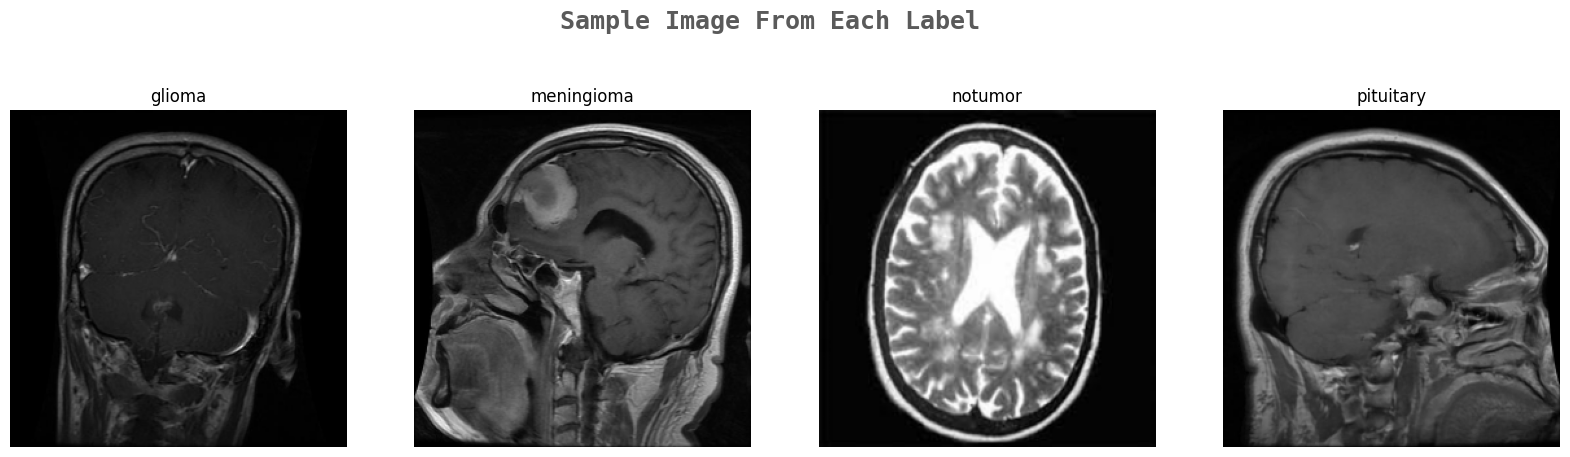

In [ ]:
# In ra một vài mẫu ảnh test:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_test[j]==i:
            ax[k].imshow(X_test[j])
            ax[k].set_title(y_test[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
# One-hot encoding cho y_test:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
X_test.shape

(91, 260, 260, 3)

In [ ]:
y_test.shape

(91, 4)

# 2. Mô hình EfficientNetB0:

## 2.1. Load và build mô hình EfficientNetB0:

In [ ]:
effnetb0 = EfficientNetB0(weights='imagenet',
                          include_top=False,
                          input_shape=(image_size,image_size,3))

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization

# Thêm các lớp head theo kiến trúc SOTA:
model_b0 = effnetb0.output
model_b0 = GlobalAveragePooling2D()(model_b0) # Lớp pooling chỉ lấy trung bình các kênh thay vì flatten toàn bộ để giảm overfiting
model_b0 = Dropout(0.3)(model_b0) # Drop out với rate = 0.3 giúp giảm overfitting.

model_b0 = Dense(256, activation="relu")(model_b0) # Lớp dense với hàm kích hoạt phi tuyến giúp model học biểu diễn tốt hơn.
model_b0 = BatchNormalization()(model_b0) # Ổn định gradient và tăng accuracy.
model_b0 = Dropout(0.3)(model_b0) # Thêm drop out cuối để giảm overfitting

outputs = Dense(4, activation="softmax")(model_b0)

model_b0 = tf.keras.Model(inputs=effnetb0.input, outputs=outputs)

model_b0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,379,559 (16.71 MB)

 Trainable params: 4,337,024 (16.54 MB)

 Non-trainable params: 42,535 (166.16 KB)

In [ ]:
# Biên dịch model:
model_b0.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

##  2.2. Fine-tunning model EfficientNetB0:

In [ ]:
tensorboard_b0 = TensorBoard(
    log_dir='log_b0',
)

checkpoint_b0 = ModelCheckpoint(
    "effnetb0_best.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr_b0 = ReduceLROnPlateau(
    monitor='val_loss', # Theo dõi val_loss để giảm learning rate
    factor=0.2, # Mức giảm lr
    patience=3, # Chờ cải thiện val_acc
    min_delta=1e-4, # Mức cải thiện thấp nhất chấp nhận
    min_lr=1e-7, # Giá trị lr thấp nhất đc giảm
    verbose=1
)


In [ ]:
# Huấn luyện mô hình:
history_b0 = model_b0.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, verbose=1, batch_size=32,
                   callbacks=[tensorboard_b0,checkpoint_b0,reduce_lr_b0])

Epoch 1/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8103 - loss: 0.5827
Epoch 1: val_loss improved from inf to 0.13570, saving model to effnetb0_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 248s 522ms/step - accuracy: 0.8105 - loss: 0.5819 - val_accuracy: 0.9635 - val_loss: 0.1357 - learning_rate: 0.0010
Epoch 2/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9594 - loss: 0.1197
Epoch 2: val_loss improved from 0.13570 to 0.08389, saving model to effnetb0_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9595 - loss: 0.1196 - val_accuracy: 0.9726 - val_loss: 0.0839 - learning_rate: 0.0010
Epoch 3/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9774 - loss: 0.0727
Epoch 3: val_loss did not improve from 0.08389
302/302 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.9774 - loss: 0.0728 - val_accuracy: 0.9677 - val_loss: 0.1022 - learning_rate: 0.0010
Epoch 4/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9808 - loss: 0.0592
Epoch 4: val_loss did not improve from 0.08389
302/302 ━━━━━━━━━━━━━━━━━━━━ 43s 142ms/step - accuracy: 0.9808 - loss: 0.0592 - val_accuracy: 0.9776 - val_loss: 0.0909 - learning_rate: 0.0010
Epoch 5/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9784 - loss: 0.0779
Epoch 5: val_loss improved from 0.08389 to 0.07646, saving model to effnetb0_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.9784 - loss: 0.0778 - val_accuracy: 0.9764 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 6/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9825 - loss: 0.0595
Epoch 6: val_loss improved from 0.07646 to 0.03664, saving model to effnetb0_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.9825 - loss: 0.0595 - val_accuracy: 0.9876 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 7/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9881 - loss: 0.0416
Epoch 7: val_loss did not improve from 0.03664
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.9881 - loss: 0.0416 - val_accuracy: 0.9822 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 8/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9874 - loss: 0.0397
Epoch 8: val_loss did not improve from 0.03664
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.9874 - loss: 0.0397 - val_accuracy: 0.9867 - val_loss: 0.0483 - learning_rate: 0.0010
Epoch 9/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9913 - loss: 0.0289
Epoch 9: val_loss did not improve from 0.03664

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.9913 - loss: 0.0290 - val_a

302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.9929 - loss: 0.0212 - val_accuracy: 0.9930 - val_loss: 0.0237 - learning_rate: 2.0000e-04
Epoch 11/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9965 - loss: 0.0092
Epoch 11: val_loss improved from 0.02371 to 0.02174, saving model to effnetb0_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9965 - loss: 0.0092 - val_accuracy: 0.9930 - val_loss: 0.0217 - learning_rate: 2.0000e-04
Epoch 12/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9984 - loss: 0.0046
Epoch 12: val_loss did not improve from 0.02174
302/302 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.9984 - loss: 0.0046 - val_accuracy: 0.9934 - val_loss: 0.0233 - learning_rate: 2.0000e-04
Epoch 13/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9984 - loss: 0.0049
Epoch 13: val_loss did not improve from 0.02174
302/302 ━━━━━━━━━━━━━━━━━━━━ 79s 147ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9946 - val_loss: 0.0235 - learning_rate: 2.0000e-04
Epoch 14/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9991 - loss: 0.0028
Epoch 14: val_loss did not improve from 0.02174

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
302/302 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.9991 - l

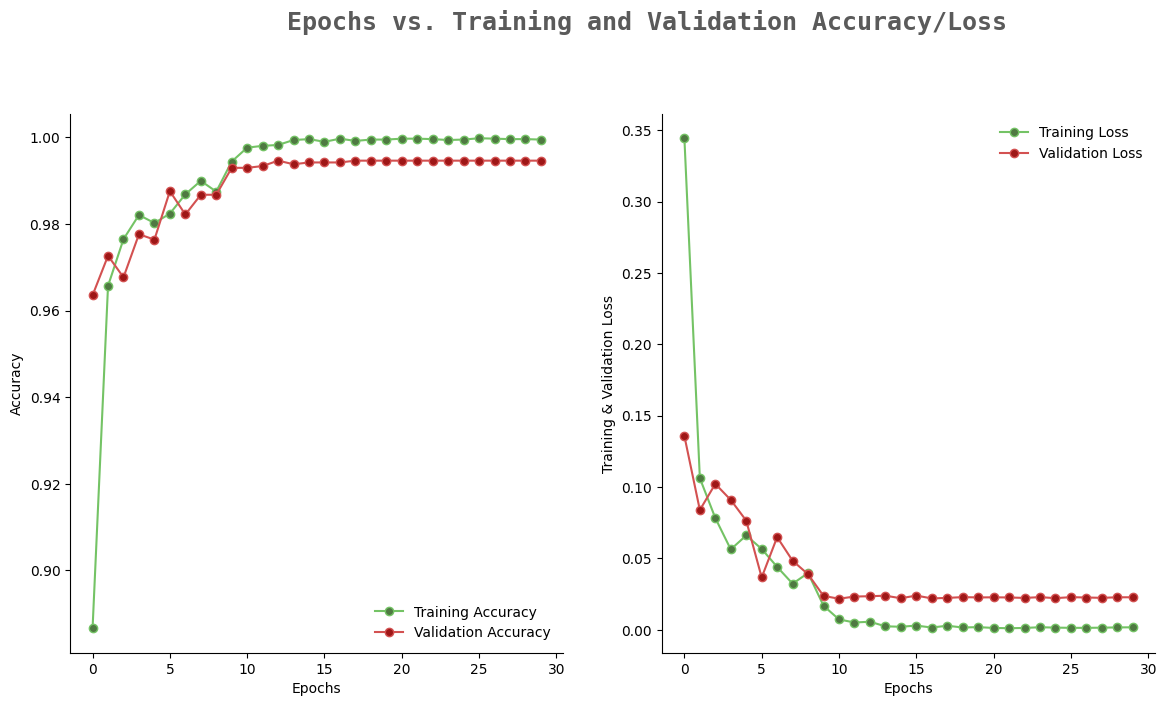

In [ ]:
# In ra quá trình huấn luyện:
filterwarnings('ignore')

epochs = [i for i in range(30)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history_b0.history['accuracy']
train_loss = history_b0.history['loss']
val_acc = history_b0.history['val_accuracy']
val_loss = history_b0.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

## 2.3. Đánh giá mô hình trên tập test:

In [ ]:
import time
import numpy as np

# ĐO INFERENCE TIME:
start = time.time()
pred_b0 = model_b0.predict(X_test, verbose=0)
end = time.time()

# TÍNH THỜI GIAN:
total_time = end - start
avg_time_per_image = total_time / len(X_test)

# CHUYỂN ĐỔI OUTPUT:
pred_b0 = np.argmax(pred_b0, axis=1)
y_test_new = np.argmax(y_test, axis=1)

# IN KẾT QUẢ:
print(f"Total inference time: {total_time:.4f} seconds")
print(f"Average time per image: {avg_time_per_image*1000:.4f} ms/image")


Total inference time: 20.4632 seconds
Average time per image: 224.8704 ms/image


In [ ]:
print(classification_report(y_test_new,pred_b0))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        49
           1       0.87      1.00      0.93        13
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00         9

    accuracy                           0.98        91
   macro avg       0.97      0.98      0.97        91
weighted avg       0.98      0.98      0.98        91



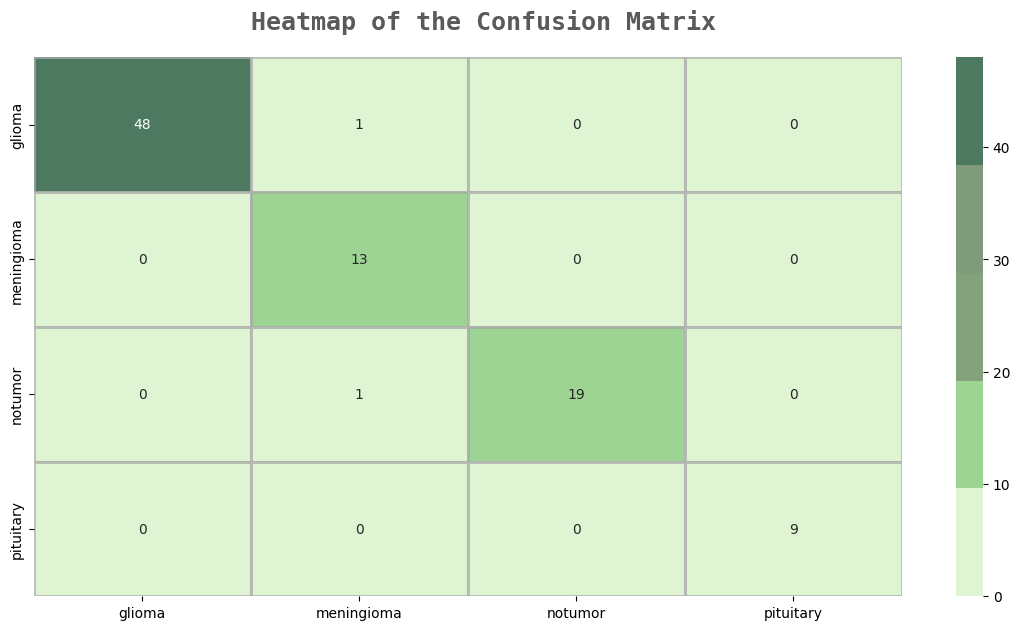

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred_b0),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## 2.4. Tính toán chỉ số False Negative Rate của model:

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_false_negative_rate(y_true_numerical, y_pred_numerical, all_labels_list):
    """
    Calculates the False Negative Rate for actual tumor images misclassified as 'no_tumor'.

    Args:
        y_true_numerical (np.ndarray): True labels (numerical).
        y_pred_numerical (np.ndarray): Predicted labels (numerical).
        all_labels_list (list): List of all possible string labels, where 'notumor' is identified.

    Returns:
        float: The False Negative Rate.
    """
    # Get the confusion matrix
    cm = confusion_matrix(y_true_numerical, y_pred_numerical)

    # Find the index of 'no_tumor'
    no_tumor_idx = all_labels_list.index('notumor')

    # Identify tumor classes (all except 'no_tumor')
    tumor_indices = [i for i, label in enumerate(all_labels_list) if label != 'notumor']

    # Sum of actual tumor images
    total_actual_tumor = 0
    for idx in tumor_indices:
        total_actual_tumor += cm[idx, :].sum()

    # Number of actual tumor images incorrectly predicted as 'no_tumor' (False Negatives in this context)
    # These are cases where true label is a tumor, but predicted label is 'no_tumor'
    misclassified_as_no_tumor = 0
    for idx in tumor_indices:
        misclassified_as_no_tumor += cm[idx, no_tumor_idx]

    if total_actual_tumor == 0:
        return 0.0 # Avoid division by zero if there are no actual tumor cases

    false_negative_rate = misclassified_as_no_tumor / total_actual_tumor

    print(f"Total actual tumor images: {total_actual_tumor}")
    print(f"Number of actual tumor images misclassified as 'no_tumor': {misclassified_as_no_tumor}")
    print(f"False Negative Rate (actual tumor predicted as no_tumor): {false_negative_rate:.4f}")

    return false_negative_rate


In [ ]:
# Apply the function to the original model's results
print("False Negative Rate for the EfficientNetB0 model:")
effnet_b0_fnr = calculate_false_negative_rate(y_test_new, pred_b0, labels)

False Negative Rate for the EfficientNetB0 model:
Total actual tumor images: 71
Number of actual tumor images misclassified as 'no_tumor': 0
False Negative Rate (actual tumor predicted as no_tumor): 0.0000


In [ ]:
# Lưu model lên drive:
model_b0.save("/content/drive/MyDrive/Image_Processing_And_Application/Đồ Án/effnetb0_model.keras")

-  Như vậy ***EfficientNetB0*** đạt **accuracy = 0.98**, **Inference Time = 224.8704 ms/image** trên tập test và có chỉ số **FNR = 0.0000**.

# 3. Mô hình EfficientNetB2:

## 3.0. Load lại dữ liệu cho mô hình:

In [ ]:
train_dir = "/content/brain_tumor/Epic and CSCR hospital Dataset/Train"
test_dir  = "/content/brain_tumor/Epic and CSCR hospital Dataset/Test"

In [ ]:
# Đọc dữ liệu:
X_train_data = []
y_train_data = []
X_test_data = []
y_test_data = []
image_size = 260

# Load training data
for i in labels:
    folderPath = os.path.join(train_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading training {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train_data.append(img)
        y_train_data.append(i)

# Load testing data
for i in labels:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading testing {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test_data.append(img)
        y_test_data.append(i)

X_train_data = np.array(X_train_data)
y_train_data = np.array(y_train_data)
X_test_data = np.array(X_test_data)
y_test_data = np.array(y_test_data)

print(f"Original training data shape: {X_train_data.shape}")
print(f"Original testing data shape: {X_test_data.shape}")

Loading testing pituitary: 100%|██████████| 626/626 [00:01<00:00, 581.07it/s]


Original training data shape: (9650, 260, 260, 3)
Original testing data shape: (2414, 260, 260, 3)


In [ ]:
# Gộp hai tập thành một tập train:
X_train_data = np.concatenate((X_train_data, X_test_data), axis=0)
y_train_data = np.concatenate((y_train_data, y_test_data), axis=0)

In [ ]:
X_train_data, y_train_data = shuffle(X_train_data,y_train_data, random_state=101)

In [ ]:
# Split original training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=101)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (9651, 260, 260, 3)
Validation set shape: (2413, 260, 260, 3)


In [ ]:
# Performing One Hot Encoding on the labels after converting it into numerical values:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

In [ ]:
y_train.shape

(9651, 4)

In [ ]:
y_val.shape

(2413, 4)

In [ ]:
X_test.shape

(91, 260, 260, 3)

In [ ]:
y_test.shape

(91, 4)

In [ ]:
X_test.shape

(91, 260, 260, 3)

In [ ]:
del X_train_data
del y_train_data
del X_test_data
del y_test_data
del y_test_new
del y_val_new
del y_train_new
import gc
gc.collect()

2544

## 3.1. Load và build mô hình:


In [ ]:
from tensorflow.keras.applications import EfficientNetB2
effnetb2 = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
print("EfficientNetB2 base model loaded successfully.")

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EfficientNetB2 base model loaded successfully.


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
# Thêm các lớp head theo kiến trúc SOTA:
model_b2 = effnetb2.output
model_b2 = GlobalAveragePooling2D()(model_b2) # Lớp pooling chỉ lấy trung bình các kênh thay vì flatten toàn bộ để giảm overfiting
model_b2 = Dropout(0.3)(model_b2) # Drop out với rate = 0.3 giúp giảm overfitting.

model_b2 = Dense(256, activation="relu")(model_b2) # Lớp dense với hàm kích hoạt phi tuyến giúp model học biểu diễn tốt hơn.
model_b2 = BatchNormalization()(model_b2) # Ổn định gradient và tăng accuracy.
model_b2 = Dropout(0.3)(model_b2) # Thêm drop out cuối để giảm overfitting

outputs = Dense(4, activation="softmax")(model_b2)

model_b2 = tf.keras.Model(inputs=effnetb2.input, outputs=outputs)

model_b2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 261, 261,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 130, 130,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 130, 130,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 130, 130,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 130, 130,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │        512 │ block1a_se_excit

 Total params: 8,131,325 (31.02 MB)

 Trainable params: 8,063,238 (30.76 MB)

 Non-trainable params: 68,087 (265.97 KB)

## 3.2. Fine-tunning mô hình:

In [ ]:
model_b2.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard_b2 = TensorBoard(
    log_dir='log_b2',
)

checkpoint_b2 = ModelCheckpoint(
    "effnetb2_best.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr_b2 = ReduceLROnPlateau(
    monitor='val_loss', # Theo dõi val_loss để giảm learning rate
    factor=0.2, # Mức giảm lr
    patience=3, # Chờ cải thiện val_acc
    min_delta=1e-4, # Mức cải thiện thấp nhất chấp nhận
    min_lr=1e-7, # Giá trị lr thấp nhất đc giảm
    verbose=1
)

In [ ]:
history_b2 = model_b2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=1, batch_size=32,
                   callbacks=[tensorboard_b2, checkpoint_b2, reduce_lr_b2])
print("EfficientNetB2 model training completed.")

Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.8222 - loss: 0.5594
Epoch 1: val_loss improved from inf to 0.10137, saving model to effnetb2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 350s 601ms/step - accuracy: 0.8224 - loss: 0.5586 - val_accuracy: 0.9652 - val_loss: 0.1014 - learning_rate: 0.0010
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9662 - loss: 0.1124
Epoch 2: val_loss did not improve from 0.10137
302/302 ━━━━━━━━━━━━━━━━━━━━ 83s 274ms/step - accuracy: 0.9662 - loss: 0.1124 - val_accuracy: 0.9731 - val_loss: 0.1800 - learning_rate: 0.0010
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9782 - loss: 0.0701
Epoch 3: val_loss improved from 0.10137 to 0.08612, saving model to effnetb2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 83s 276ms/step - accuracy: 0.9782 - loss: 0.0701 - val_accuracy: 0.9731 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 4/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9820 - loss: 0.0546
Epoch 4: val_loss did not improve from 0.08612
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - accuracy: 0.9820 - loss: 0.0546 - val_accuracy: 0.9648 - val_loss: 0.1038 - learning_rate: 0.0010
Epoch 5/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9780 - loss: 0.0707
Epoch 5: val_loss did not improve from 0.08612
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 273ms/step - accuracy: 0.9780 - loss: 0.0707 - val_accuracy: 0.9747 - val_loss: 0.0869 - learning_rate: 0.0010
Epoch 6/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9831 - loss: 0.0508
Epoch 6: val_loss did not improve from 0.08612

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - accuracy: 0.9831 - loss: 0.0508 - val_a

302/302 ━━━━━━━━━━━━━━━━━━━━ 84s 277ms/step - accuracy: 0.9927 - loss: 0.0246 - val_accuracy: 0.9934 - val_loss: 0.0275 - learning_rate: 2.0000e-04
Epoch 8/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9982 - loss: 0.0093
Epoch 8: val_loss improved from 0.02753 to 0.02371, saving model to effnetb2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 83s 276ms/step - accuracy: 0.9982 - loss: 0.0093 - val_accuracy: 0.9934 - val_loss: 0.0237 - learning_rate: 2.0000e-04
Epoch 9/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9992 - loss: 0.0039
Epoch 9: val_loss improved from 0.02371 to 0.02273, saving model to effnetb2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 84s 277ms/step - accuracy: 0.9992 - loss: 0.0039 - val_accuracy: 0.9938 - val_loss: 0.0227 - learning_rate: 2.0000e-04
Epoch 10/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9998 - loss: 0.0018
Epoch 10: val_loss did not improve from 0.02273
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9942 - val_loss: 0.0254 - learning_rate: 2.0000e-04
Epoch 11/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9992 - loss: 0.0024
Epoch 11: val_loss did not improve from 0.02273
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - accuracy: 0.9992 - loss: 0.0024 - val_accuracy: 0.9930 - val_loss: 0.0319 - learning_rate: 2.0000e-04
Epoch 12/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9994 - loss: 0.0033
Epoch 12: val_loss did not improve from 0.02273

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - accuracy: 0.9994 - l

302/302 ━━━━━━━━━━━━━━━━━━━━ 83s 275ms/step - accuracy: 0.9999 - loss: 9.1845e-04 - val_accuracy: 0.9938 - val_loss: 0.0226 - learning_rate: 4.0000e-05
Epoch 16/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9999 - loss: 9.1693e-04
Epoch 16: val_loss did not improve from 0.02260
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - accuracy: 0.9999 - loss: 9.1802e-04 - val_accuracy: 0.9938 - val_loss: 0.0230 - learning_rate: 4.0000e-05
Epoch 17/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9999 - loss: 7.0759e-04
Epoch 17: val_loss did not improve from 0.02260
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - accuracy: 0.9999 - loss: 7.0756e-04 - val_accuracy: 0.9938 - val_loss: 0.0231 - learning_rate: 4.0000e-05
Epoch 18/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9999 - loss: 0.0010
Epoch 18: val_loss did not improve from 0.02260

Epoch 18: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - a

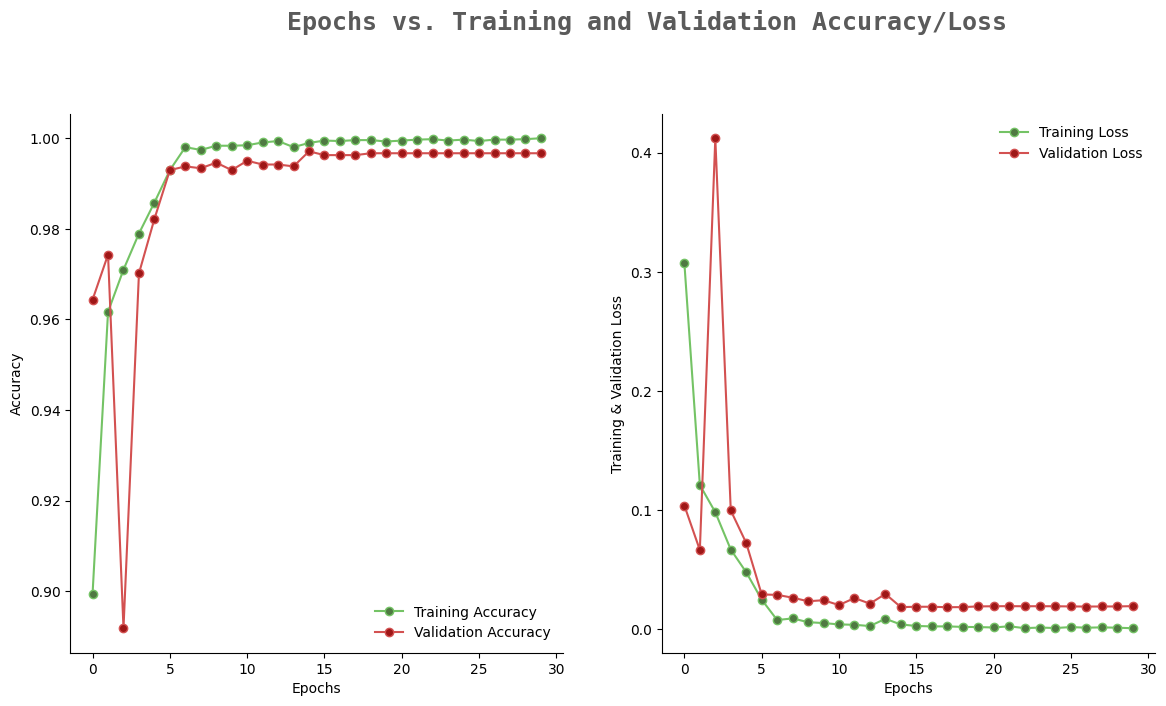

In [ ]:
# In ra quá trình huấn luyện:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history_b2.history['accuracy']
train_loss = history_b2.history['loss']
val_acc = history_b2.history['val_accuracy']
val_loss = history_b2.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

## 3.3. Đánh giá mô hình trên tập test:

In [ ]:
import time
import numpy as np

# ĐO INFERENCE TIME:
start = time.time()
pred_b2 = model_b2.predict(X_test, verbose=0)
end = time.time()

# TÍNH THỜI GIAN:
total_time = end - start
avg_time_per_image = total_time / len(X_test)

# CHUYỂN ĐỔI OUTPUT:
pred_b2 = np.argmax(pred_b2, axis=1)
y_test_new = np.argmax(y_test, axis=1)

# IN KẾT QUẢ:
print(f"Total inference time: {total_time:.4f} seconds")
print(f"Average time per image: {avg_time_per_image*1000:.4f} ms/image")


Total inference time: 29.9986 seconds
Average time per image: 329.6547 ms/image


In [ ]:
print(classification_report(y_test_new,pred_b2))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        49
           1       0.93      1.00      0.96        13
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00         9

    accuracy                           0.99        91
   macro avg       0.98      0.99      0.99        91
weighted avg       0.99      0.99      0.99        91



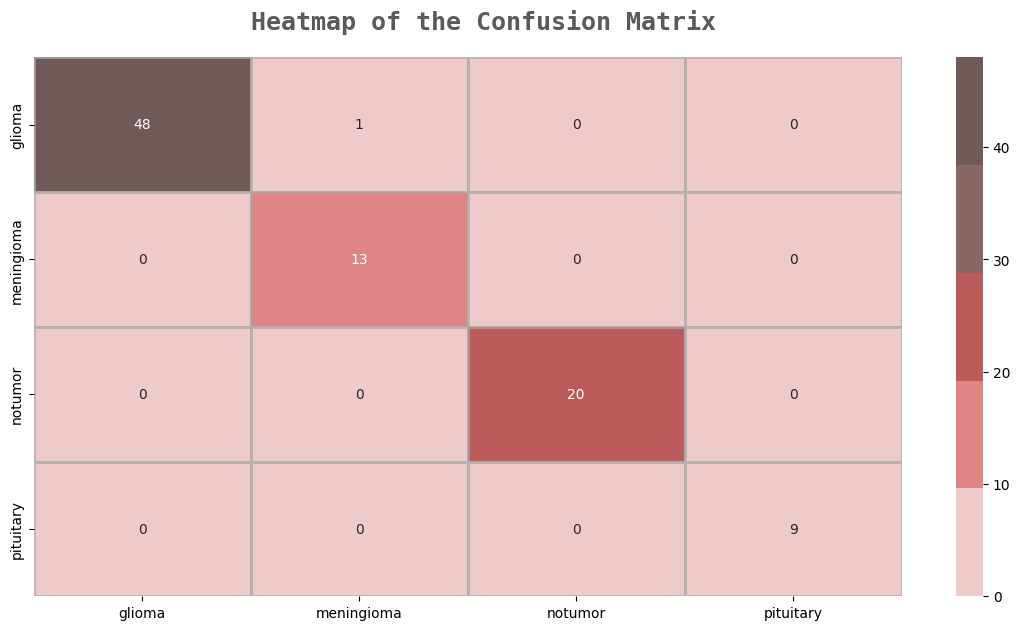

In [ ]:
# In confusion matrix:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred_b2),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_red[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
ax.set.xlabel('Predicted')
ax.set.ylabel('Actual')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## 3.4. Tính toán chỉ số False Negative Rate của mô hình:

In [ ]:
# Tính toán chỉ số False Negative Rate của mô hình:
print("False Negative Rate for the EfficientNetB2 model:")
calculate_false_negative_rate(y_test_new, pred_b2, labels)

False Negative Rate for the EfficientNetB2 model:
Total actual tumor images: 71
Number of actual tumor images misclassified as 'no_tumor': 0
False Negative Rate (actual tumor predicted as no_tumor): 0.0000


np.float64(0.0)

In [ ]:
# Lưu model lên drive:
model_b2.save("/content/drive/MyDrive/Image_Processing_And_Application/Do_An/EFFNETB2_RGB_260_INPUT.keras")

- Như vậy mô hình ***EfficientNetB2*** đạt được **accuracy = 0.99**, **inference time = 329.6547 ms/image** và chỉ số **FNR = 0.0000**

# 4. Mô hình EfficientNetB3:

## 4.1. Load lại dữ liệu cho EfficientNetB3:

In [ ]:
train_dir = "/content/brain_tumor/Epic and CSCR hospital Dataset/Train"
test_dir  = "/content/brain_tumor/Epic and CSCR hospital Dataset/Test"

In [ ]:
# Đọc dữ liệu:
X_train_data = []
y_train_data = []
X_test_data = []
y_test_data = []
image_size = 300

# Load training data
for i in labels:
    folderPath = os.path.join(train_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading training {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train_data.append(img)
        y_train_data.append(i)

# Load testing data
for i in labels:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading testing {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test_data.append(img)
        y_test_data.append(i)

X_train_data = np.array(X_train_data)
y_train_data = np.array(y_train_data)
X_test_data = np.array(X_test_data)
y_test_data = np.array(y_test_data)

print(f"Original training data shape: {X_train_data.shape}")
print(f"Original testing data shape: {X_test_data.shape}")

Loading testing pituitary: 100%|██████████| 626/626 [00:01<00:00, 329.56it/s]


Original training data shape: (9650, 300, 300, 3)
Original testing data shape: (2414, 300, 300, 3)


In [ ]:
X_train_data = np.concatenate((X_train_data, X_test_data), axis=0)
y_train_data = np.concatenate((y_train_data, y_test_data), axis=0)

In [ ]:
X_train_data, y_train_data = shuffle(X_train_data,y_train_data, random_state=101)

In [ ]:
X_train_data.shape

In [ ]:
# Split original training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=101)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

In [ ]:
# Performing One Hot Encoding on the labels after converting it into numerical values:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

In [ ]:
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Testing labels shape: {y_test.shape}")

## 4.2. Load và bulid mô hình EfficientNetB3:

In [ ]:
# Load và bulid mô hình EfficientNetB3:
from tensorflow.keras.applications import EfficientNetB3
effnetb3 = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
print("EfficientNetB3 base model loaded successfully.")

In [ ]:
# Thêm các lớp head theo kiến trúc SOTA:
model_b3 = effnetb3.output
model_b3 = GlobalAveragePooling2D()(model_b3) # Lớp pooling chỉ lấy trung bình các kênh thay vì flatten toàn bộ để giảm overfiting
model_b3 = Dropout(0.3)(model_b3) # Drop out với rate = 0.3 giúp giảm overfitting.

model_b3 = Dense(256, activation="relu")(model_b3) # Lớp dense với hàm kích hoạt phi tuyến giúp model học biểu diễn tốt hơn.
model_b3 = BatchNormalization()(model_b3) # Ổn định gradient và tăng accuracy.
model_b3 = Dropout(0.3)(model_b3) # Thêm drop out cuối để giảm overfitting

outputs = Dense(4, activation="softmax")(model_b3)

model_b3 = tf.keras.Model(inputs=effnetb3.input, outputs=outputs)

model_b3.summary()

In [ ]:
# Biên dịch model:
model_b3.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

## 4.3. Fine-tunning model:

In [ ]:
tensorboard_b3 = TensorBoard(
    log_dir='log_b3',
)

checkpoint_b3 = ModelCheckpoint(
    "effnetb3_best.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr_b3 = ReduceLROnPlateau(
    monitor='val_loss', # Theo dõi val_loss để giảm learning rate
    factor=0.2, # Mức giảm lr
    patience=3, # Chờ cải thiện val_acc
    min_delta=1e-4, # Mức cải thiện thấp nhất chấp nhận
    min_lr=1e-7, # Giá trị lr thấp nhất đc giảm
    verbose=1
)

In [ ]:
history_b3 = model_b3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=1, batch_size=32,
                   callbacks=[tensorboard_b3, checkpoint_b3, reduce_lr_b3])
print("EfficientNetB3 model training completed.")

In [ ]:
# In ra quá trình huấn luyện:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history_b3.history['accuracy']
train_loss = history_b3.history['loss']
val_acc = history_b3.history['val_accuracy']
val_loss = history_b3.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

## 4.4. Đánh giá mô hình trên tập test:

In [ ]:
import time
import numpy as np

# ĐO INFERENCE TIME:
start = time.time()
pred_b3 = model_b3.predict(X_test, verbose=0)
end = time.time()

# TÍNH THỜI GIAN:
total_time = end - start
avg_time_per_image = total_time / len(X_test)

# CHUYỂN ĐỔI OUTPUT:
pred_b3 = np.argmax(pred_b3, axis=1)
y_test_new = np.argmax(y_test, axis=1)

# IN KẾT QUẢ:
print(f"Total inference time: {total_time:.4f} seconds")
print(f"Average time per image: {avg_time_per_image*1000:.4f} ms/image")


In [ ]:
print(classification_report(y_test_new,pred_b3))

In [ ]:
# In confusion matrix:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred_b3),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
ax.set.xlabel('Predicted')
ax.set.ylabel('Actual')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_red[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## 4.5. Tính toán chỉ số False Negative Rate của mô hình:

In [ ]:
# Tính toán chỉ số false negative rate của mô hình:
print("False Negative Rate for the EfficientNetB3 model:")
calculate_false_negative_rate(y_test_new, pred_b3, labels)

In [ ]:
# Lưu model lên drive:
model_b3.save("/content/drive/MyDrive/Image_Processing_And_Application/Đồ Án/effnetb3_model.keras")

- Như vậy mô hình ***EfficientNetB3*** đạt được **Accuracy = 0.97**, **Time Inference = 98.1799 ms/image** và có chỉ số **FNR = 0.0000**!

# 5. Mô hình EfficientNetV2-S:

## 5.1. Load và build mô hình:

In [ ]:
# Load và bulid mô hình EfficientNetV2S:
from tensorflow.keras.applications import EfficientNetV2S
effnetV2S = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
print("EfficientNetV2S base model loaded successfully.")

In [ ]:
# Thêm các lớp head theo kiến trúc SOTA:
model_v2s = effnetV2S.output
model_v2s = GlobalAveragePooling2D()(model_v2s) # Lớp pooling chỉ lấy trung bình các kênh thay vì flatten toàn bộ để giảm overfiting
model_v2s = Dropout(0.3)(model_v2s) # Drop out với rate = 0.3 giúp giảm overfitting.

model_v2s = Dense(256, activation="relu")(model_v2s) # Lớp dense với hàm kích hoạt phi tuyến giúp model học biểu diễn tốt hơn.
model_v2s = BatchNormalization()(model_v2s) # Ổn định gradient và tăng accuracy.
model_v2s = Dropout(0.3)(model_v2s) # Thêm drop out cuối để giảm overfitting

outputs = Dense(4, activation="softmax")(model_v2s)

model_v2s = tf.keras.Model(inputs=effnetV2S.input, outputs=outputs)

model_v2s.summary()

In [ ]:
# Biên dịch model:
model_v2s.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

## 5.2. Fine-tunning mô hình:

In [ ]:
tensorboard_v2s = TensorBoard(
    log_dir='log_v2s',
)

checkpoint_v2s = ModelCheckpoint(
    "effnetv2s_best.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr_v2s = ReduceLROnPlateau(
    monitor='val_loss', # Theo dõi val_loss để giảm learning rate
    factor=0.2, # Mức giảm lr
    patience=3, # Chờ cải thiện val_acc
    min_delta=1e-4, # Mức cải thiện thấp nhất chấp nhận
    min_lr=1e-7, # Giá trị lr thấp nhất đc giảm
    verbose=1
)

In [ ]:
# Fine-tunning model:
history_v2s = model_v2s.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=1, batch_size=32,
                   callbacks=[tensorboard_v2s, checkpoint_v2s, reduce_lr_v2s])
print("EfficientNetV2S model training completed.")

In [ ]:
# In ra quá trình huấn luyện:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history_v2s.history['accuracy']
train_loss = history_v2s.history['loss']
val_acc = history_v2s.history['val_accuracy']
val_loss = history_v2s.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

## 5.3. Đánh giá mô hình trên tập test:

In [ ]:
import time
import numpy as np

# ĐO INFERENCE TIME:
start = time.time()
pred_v2s = model_v2s.predict(X_test, verbose=0)
end = time.time()

# TÍNH THỜI GIAN:
total_time = end - start
avg_time_per_image = total_time / len(X_test)

# CHUYỂN ĐỔI OUTPUT:
pred_v2s = np.argmax(pred_v2s, axis=1)
y_test_new = np.argmax(y_test, axis=1)

# IN KẾT QUẢ:
print(f"Total inference time: {total_time:.4f} seconds")
print(f"Average time per image: {avg_time_per_image*1000:.4f} ms/image")

In [ ]:
print(classification_report(y_test_new,pred_v2s))

In [ ]:
# In confusion matrix:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred_v2s),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
ax.set.xlabel('Predicted')
ax.set.ylabel('Actual')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## 5.4. Tính toán chỉ số False Negative Rate của mô hình:

In [ ]:
# Tính toán chỉ số False Negative Rate của model:
print("False Negative Rate for the EfficientNetV2S model:")
calculate_false_negative_rate(y_test_new, pred_v2s, labels)

In [ ]:
# Lưu model lên drive:
model_v2s.save("/content/drive/MyDrive/Image_Processing_And_Application/Đồ Án/effnetv2s_model.keras")